# Bilateral International Migration prediction using Deep Learning #


Ludwig-Maximilians-Universität M.Economics Machine Learning Applications - WS2020/21 Term Paper

Code by: Yunting LIU,  15.03.2021

# Introduction

For an introduction to the research topic and methodology see accompanying document "Notes to exam project_bilateral migration prediction"

# Initialising

In [1]:
import os
import wget
from pathlib import Path

import pandas as pd
import numpy as np
import xarray
#import pandas_profiling

from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.metrics import Metric

import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error, r2_score 
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as kb
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping


import xgboost as xgb
from typing import Tuple
from xgboost import XGBRegressor

import shap
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.colors import SymLogNorm
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999



/Users/jacqueline/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/jacqueline/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# Set a random seed to ensure result reproducibility
import random as python_random
random_seed = 123
np.random.seed(random_seed)
python_random.seed(random_seed)
tf.random.set_seed(random_seed)



In [3]:
# Change current working directory for convenience

os.chdir('/Users/jacqueline/Documents/Study/LMU/2020WS/Machine Learning Applications/exam_paper')
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /Users/jacqueline/Documents/Study/LMU/2020WS/Machine Learning Applications/exam_paper


# Data

The main data set is made available from [2] and downloaded on the following website : [https://www.sciencedirect.com/science/article/pii/S0304387819304900](https://www.sciencedirect.com/science/article/pii/S0304387819304900)

For convenience i have downloaded a copy of this in my local directory.

## Data import 

In [4]:
os.getcwd()

'/Users/jacqueline/Documents/Study/LMU/2020WS/Machine Learning Applications/exam_paper'

In [5]:
data_in = pd.read_stata('./data/replication_bilateral.dta')

In [6]:
# skip data columns with "GTI" - these relate to internet search keywords which I wish to exclude for this first modelling
# further skip all the log transformation columns
exclude_log_cols = ['o_log_pop', 'd_log_pop', 'o_log_gdp', 'd_log_gdp', 'log_mig_stock']
cols = [c for c in data_in.columns if (c.lower()[:3] != 'gti' and c.lower() not in exclude_log_cols)]

data=data_in[cols].copy()

data

,pair_id,iso3n_o,iso3n_d,year,source_country,iso3_o,iso3_d,log_mig,fwd_log_mig,o_sl_uem_totl_zs,o_sp_pop_0014_to_zs,sfi_sfi,pol4_autoc,o_IT_CEL_SETS_P2,o_IT_NET_USER_P2,o_number_weather,o_number_nonweather,mig_stock_tot,o_French,o_Spanish,o_English,d_GDP,d_pop,o_GDP,o_pop,tot_mig,fwd_tot_mig,iso3n_oXyear,iso3n_dXyear
0,171,32,36,2004,Argentina,ARG,AUS,5.950643,5.961005,12.6,26.647324,4.0,0.0,35.272288,16.036684,3,0,NaN,0.0,0.99,0.00,671.733032,20.127401,204.133987,38.728775,384.000000,386.999939,64128,72144
1,171,32,36,2005,Argentina,ARG,AUS,5.961005,5.590987,10.6,26.321699,2.0,0.0,57.328994,17.720583,1,0,NaN,0.0,0.99,0.00,693.339050,20.394800,222.911011,39.145489,387.999939,267.000061,64160,72180
2,171,32,36,2006,Argentina,ARG,AUS,5.590987,5.164786,10.1,26.007032,2.0,0.0,80.818826,20.927202,1,0,NaN,0.0,0.99,0.00,714.074097,20.697899,241.641998,39.558746,268.000061,173.999985,64192,72216
3,171,32,36,2007,Argentina,ARG,AUS,5.164786,5.170484,8.5,25.702198,2.0,0.0,102.721528,25.946633,3,0,NaN,0.0,0.99,0.00,740.924133,20.827599,260.889984,39.969906,174.999985,175.000015,64224,72252
4,171,32,36,2008,Argentina,ARG,AUS,5.170484,5.087596,7.8,25.410353,2.0,0.0,117.221183,28.112623,1,1,NaN,0.0,0.99,0.00,768.354980,21.249199,268.911987,40.381863,176.000015,161.000015,64256,72288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23942,7021,716,752,2010,Zimbabwe,ZWE,SWE,3.178054,3.433987,5.5,41.234154,17.0,2.0,58.882106,6.400000,2,2,134.0,0.0,0.00,0.42,420.871033,9.378126,5.202304,13.973897,24.000000,29.999998,1439160,1511520
23943,7021,716,752,2011,Zimbabwe,ZWE,SWE,3.433987,3.295837,5.4,40.806862,17.0,2.0,68.868781,8.400000,1,1,153.0,0.0,0.00,0.42,432.084076,9.449212,5.821660,14.255593,30.999998,26.000002,1439876,1512272
23944,7021,716,752,2012,Zimbabwe,ZWE,SWE,3.295837,2.772589,5.3,40.244041,17.0,2.0,91.909382,12.000000,0,0,155.0,0.0,0.00,0.42,430.846985,9.519374,6.436730,14.565481,27.000002,15.000000,1440592,1513024
23945,7021,716,752,2013,Zimbabwe,ZWE,SWE,2.772589,3.688879,5.4,39.459351,17.0,1.0,96.349867,15.500000,2,0,159.0,0.0,0.00,0.42,436.371979,9.600380,6.725359,14.898092,16.000000,39.000000,1441308,1513776


In [7]:
data.shape

(23947, 29)

In [8]:
data.dtypes

pair_id                  int32
iso3n_o                  int32
iso3n_d                  int32
year                     int32
source_country          object
iso3_o                  object
iso3_d                  object
log_mig                float32
fwd_log_mig            float32
o_sl_uem_totl_zs       float32
o_sp_pop_0014_to_zs    float32
sfi_sfi                float64
pol4_autoc             float64
o_IT_CEL_SETS_P2       float64
o_IT_NET_USER_P2       float64
o_number_weather          int8
o_number_nonweather       int8
mig_stock_tot          float32
o_French               float64
o_Spanish              float64
o_English              float64
d_GDP                  float32
d_pop                  float32
o_GDP                  float32
o_pop                  float32
tot_mig                float32
fwd_tot_mig            float32
iso3n_oXyear             int32
iso3n_dXyear             int32
dtype: object

## Data Exploration 

In [9]:
# take a look into a random subset of data
# pandas_profiling.ProfileReport(data.sample(n = 5000, random_state = 123))

# Model Training 

## Data preparation for modelling, split and feature selection 

In [10]:
data_modelling = data

# use log(migration) as model target; this forces models to always predict a positive value for migration
target = 'fwd_log_mig' 

unused_feat = ['Set', 'iso3n_o', 'iso3n_d', 'source_country', 'iso3n_oXyear', 'iso3n_dXyear', 'tot_mig', 'fwd_tot_mig', 'log_mig']

features = [ col for col in data_modelling.columns if col not in unused_feat+[target]] 
col_used = [ col for col in data_modelling.columns if col not in unused_feat] 

In [11]:
data_modelling

,pair_id,iso3n_o,iso3n_d,year,source_country,iso3_o,iso3_d,log_mig,fwd_log_mig,o_sl_uem_totl_zs,o_sp_pop_0014_to_zs,sfi_sfi,pol4_autoc,o_IT_CEL_SETS_P2,o_IT_NET_USER_P2,o_number_weather,o_number_nonweather,mig_stock_tot,o_French,o_Spanish,o_English,d_GDP,d_pop,o_GDP,o_pop,tot_mig,fwd_tot_mig,iso3n_oXyear,iso3n_dXyear
0,171,32,36,2004,Argentina,ARG,AUS,5.950643,5.961005,12.6,26.647324,4.0,0.0,35.272288,16.036684,3,0,NaN,0.0,0.99,0.00,671.733032,20.127401,204.133987,38.728775,384.000000,386.999939,64128,72144
1,171,32,36,2005,Argentina,ARG,AUS,5.961005,5.590987,10.6,26.321699,2.0,0.0,57.328994,17.720583,1,0,NaN,0.0,0.99,0.00,693.339050,20.394800,222.911011,39.145489,387.999939,267.000061,64160,72180
2,171,32,36,2006,Argentina,ARG,AUS,5.590987,5.164786,10.1,26.007032,2.0,0.0,80.818826,20.927202,1,0,NaN,0.0,0.99,0.00,714.074097,20.697899,241.641998,39.558746,268.000061,173.999985,64192,72216
3,171,32,36,2007,Argentina,ARG,AUS,5.164786,5.170484,8.5,25.702198,2.0,0.0,102.721528,25.946633,3,0,NaN,0.0,0.99,0.00,740.924133,20.827599,260.889984,39.969906,174.999985,175.000015,64224,72252
4,171,32,36,2008,Argentina,ARG,AUS,5.170484,5.087596,7.8,25.410353,2.0,0.0,117.221183,28.112623,1,1,NaN,0.0,0.99,0.00,768.354980,21.249199,268.911987,40.381863,176.000015,161.000015,64256,72288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23942,7021,716,752,2010,Zimbabwe,ZWE,SWE,3.178054,3.433987,5.5,41.234154,17.0,2.0,58.882106,6.400000,2,2,134.0,0.0,0.00,0.42,420.871033,9.378126,5.202304,13.973897,24.000000,29.999998,1439160,1511520
23943,7021,716,752,2011,Zimbabwe,ZWE,SWE,3.433987,3.295837,5.4,40.806862,17.0,2.0,68.868781,8.400000,1,1,153.0,0.0,0.00,0.42,432.084076,9.449212,5.821660,14.255593,30.999998,26.000002,1439876,1512272
23944,7021,716,752,2012,Zimbabwe,ZWE,SWE,3.295837,2.772589,5.3,40.244041,17.0,2.0,91.909382,12.000000,0,0,155.0,0.0,0.00,0.42,430.846985,9.519374,6.436730,14.565481,27.000002,15.000000,1440592,1513024
23945,7021,716,752,2013,Zimbabwe,ZWE,SWE,2.772589,3.688879,5.4,39.459351,17.0,1.0,96.349867,15.500000,2,0,159.0,0.0,0.00,0.42,436.371979,9.600380,6.725359,14.898092,16.000000,39.000000,1441308,1513776


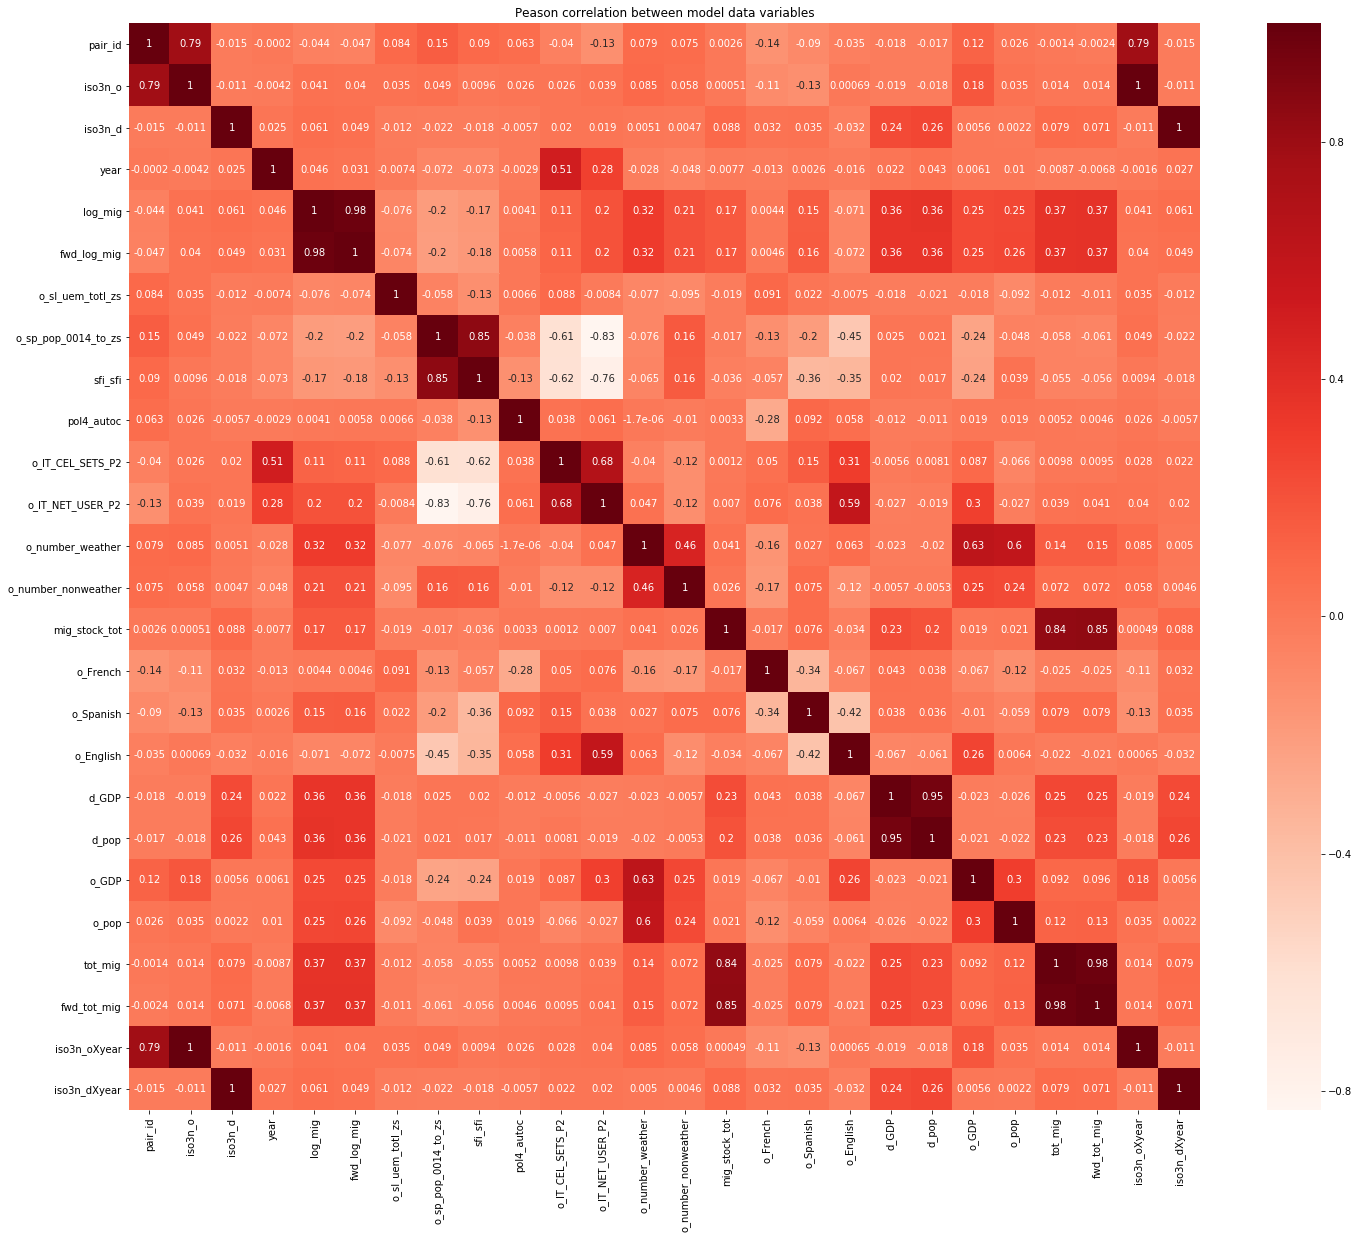

In [12]:
# Check correlation on modelling data (using Pearson Correlation)
cor = data_modelling.corr()

plt.figure(figsize=(24,20))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    
plt.title('Peason correlation between model data variables', fontsize=12)

plt.savefig('./exhibits/corr_model_data.png')

In [13]:
data_modelling = data_modelling[col_used].copy()

# convert pair_id to string
data_modelling['pair_id']= data_modelling['pair_id'].apply(str)

# in keeping with original paper, use 2004-2012 data as train set, 2013 as validation set, and 2014 as test set
if "Set" not in data_modelling.columns:
    data_modelling['Set'] = data_modelling.apply(lambda x: 'test' if x.year == 2014 else 'valid' if x.year ==2013 else 'train', axis = 1)
#    data_modelling["Set"] = np.random.choice(["train", "valid", "test"], p =[.6, .2, .2], size=(data_modelling.shape[0],))

train_indices = data_modelling[data_modelling.Set=="train"].index
valid_indices = data_modelling[data_modelling.Set=="valid"].index
test_indices = data_modelling[data_modelling.Set=="test"].index

In [14]:
data_modelling

,pair_id,year,iso3_o,iso3_d,fwd_log_mig,o_sl_uem_totl_zs,o_sp_pop_0014_to_zs,sfi_sfi,pol4_autoc,o_IT_CEL_SETS_P2,o_IT_NET_USER_P2,o_number_weather,o_number_nonweather,mig_stock_tot,o_French,o_Spanish,o_English,d_GDP,d_pop,o_GDP,o_pop,Set
0,171,2004,ARG,AUS,5.961005,12.6,26.647324,4.0,0.0,35.272288,16.036684,3,0,NaN,0.0,0.99,0.00,671.733032,20.127401,204.133987,38.728775,train
1,171,2005,ARG,AUS,5.590987,10.6,26.321699,2.0,0.0,57.328994,17.720583,1,0,NaN,0.0,0.99,0.00,693.339050,20.394800,222.911011,39.145489,train
2,171,2006,ARG,AUS,5.164786,10.1,26.007032,2.0,0.0,80.818826,20.927202,1,0,NaN,0.0,0.99,0.00,714.074097,20.697899,241.641998,39.558746,train
3,171,2007,ARG,AUS,5.170484,8.5,25.702198,2.0,0.0,102.721528,25.946633,3,0,NaN,0.0,0.99,0.00,740.924133,20.827599,260.889984,39.969906,train
4,171,2008,ARG,AUS,5.087596,7.8,25.410353,2.0,0.0,117.221183,28.112623,1,1,NaN,0.0,0.99,0.00,768.354980,21.249199,268.911987,40.381863,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23942,7021,2010,ZWE,SWE,3.433987,5.5,41.234154,17.0,2.0,58.882106,6.400000,2,2,134.0,0.0,0.00,0.42,420.871033,9.378126,5.202304,13.973897,train
23943,7021,2011,ZWE,SWE,3.295837,5.4,40.806862,17.0,2.0,68.868781,8.400000,1,1,153.0,0.0,0.00,0.42,432.084076,9.449212,5.821660,14.255593,train
23944,7021,2012,ZWE,SWE,2.772589,5.3,40.244041,17.0,2.0,91.909382,12.000000,0,0,155.0,0.0,0.00,0.42,430.846985,9.519374,6.436730,14.565481,train
23945,7021,2013,ZWE,SWE,3.688879,5.4,39.459351,17.0,1.0,96.349867,15.500000,2,0,159.0,0.0,0.00,0.42,436.371979,9.600380,6.725359,14.898092,valid


In [15]:
# Simple feature pre-processing

nunique = data_modelling.nunique()
types = data_modelling.dtypes

categorical_columns = []
categorical_dims =  {}

for col in data_modelling.columns[data_modelling.dtypes == object]:
    print(col, data_modelling[col].nunique())
    l_enc = LabelEncoder()
    data_modelling[col] = data_modelling[col].fillna("VV_likely")
    data_modelling[col] = l_enc.fit_transform(data_modelling[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

numerical_columns = []
numerical_dims =  {}    
    
for col in data_modelling.columns[data_modelling.dtypes == 'float64']:
    data_modelling.fillna(data_modelling.loc[train_indices, col].mean(), inplace=True)
#    sc = StandardScaler()
#    train[col] = sc.fit_transform(train[col].values)
#    train[col] = np.squeeze(sc.fit_transform(train[col].values.reshape(-1, 1)))
#    numerical_columns.append(col)
#    numerical_dims[col] = len(l_enc.classes_)
    

pair_id 2627
iso3_o 101
iso3_d 35
Set 3


In [16]:
categorical_columns

['pair_id', 'iso3_o', 'iso3_d', 'Set']

In [17]:
categorical_dims

{'pair_id': 2627, 'iso3_o': 101, 'iso3_d': 35, 'Set': 3}

In [18]:
data_modelling

,pair_id,year,iso3_o,iso3_d,fwd_log_mig,o_sl_uem_totl_zs,o_sp_pop_0014_to_zs,sfi_sfi,pol4_autoc,o_IT_CEL_SETS_P2,o_IT_NET_USER_P2,o_number_weather,o_number_nonweather,mig_stock_tot,o_French,o_Spanish,o_English,d_GDP,d_pop,o_GDP,o_pop,Set
0,375,2004,0,0,5.961005,12.600000,26.647324,4.0,0.0,35.272288,16.036684,3,0,9.678758,0.0,0.99,0.00,671.733032,20.127401,204.133987,38.728775,1
1,375,2005,0,0,5.590987,10.600000,26.321699,2.0,0.0,57.328994,17.720583,1,0,9.678758,0.0,0.99,0.00,693.339050,20.394800,222.911011,39.145489,1
2,375,2006,0,0,5.164786,10.100000,26.007032,2.0,0.0,80.818826,20.927202,1,0,9.678758,0.0,0.99,0.00,714.074097,20.697899,241.641998,39.558746,1
3,375,2007,0,0,5.170484,8.500000,25.702198,2.0,0.0,102.721528,25.946633,3,0,9.678758,0.0,0.99,0.00,740.924133,20.827599,260.889984,39.969906,1
4,375,2008,0,0,5.087596,7.800000,25.410353,2.0,0.0,117.221183,28.112623,1,1,9.678758,0.0,0.99,0.00,768.354980,21.249199,268.911987,40.381863,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23942,2514,2010,100,32,3.433987,5.500000,41.234154,17.0,2.0,58.882106,6.400000,2,2,134.000000,0.0,0.00,0.42,420.871033,9.378126,5.202304,13.973897,1
23943,2514,2011,100,32,3.295837,5.400000,40.806862,17.0,2.0,68.868781,8.400000,1,1,153.000000,0.0,0.00,0.42,432.084076,9.449212,5.821660,14.255593,1
23944,2514,2012,100,32,2.772589,5.300000,40.244041,17.0,2.0,91.909382,12.000000,0,0,155.000000,0.0,0.00,0.42,430.846985,9.519374,6.436730,14.565481,1
23945,2514,2013,100,32,3.688879,5.400000,39.459351,17.0,1.0,96.349867,15.500000,2,0,159.000000,0.0,0.00,0.42,436.371979,9.600380,6.725359,14.898092,2


In [19]:
# Split into train, validation and test set
X_train = data_modelling[features].values[train_indices]
y_train = data_modelling[target].values[train_indices].reshape(-1, 1)

X_valid = data_modelling[features].values[valid_indices]
y_valid = data_modelling[target].values[valid_indices].reshape(-1, 1)

X_test = data_modelling[features].values[test_indices]
y_test = data_modelling[target].values[test_indices].reshape(-1, 1)

In [20]:
data_modelling.to_csv('./data/data_modelling.csv', sep=";")

## Defining CPC and R2 as custom metric, defining CPC as loss function 

In [21]:
# Define Common Part of Commuters (CPC) and R_squared as custom metrics

class CPC(Metric):
    def __init__(self):
        self._name = "cpc"
        self._maximize = True

    def __call__(self, y_true, y_score):
        cpc = 2 * np.sum(np.minimum(y_true, y_score)) / (np.sum(y_true) + np.sum(y_score))
        return cpc

# Coefficient of determination r^2

class r_squared(Metric):
    def __init__(self):
        self._name = "r_squared"
        self._maximize = True

    def __call__(self, y_true, y_score):
        SS_res = np.sum(np.square(y_true - y_score))
        SS_tot = np.sum(np.square(y_true - np.mean(y_true)))
        r_squared = (1 - SS_res / (SS_tot))          
        return r_squared

custom_metrics = ['mae', 'mse', 'rmse', r_squared, CPC]

In [22]:
# Again for Keras models
# Common Part of Commuters
def cpc_keras(y_true, y_pred):
    return (2.0 * kb.sum(kb.minimum(y_true, y_pred))) / (kb.sum(y_true) + kb.sum(y_pred))

# Coefficient of determination r^2
def r_squared_keras(y_true, y_pred):
    SS_res = kb.sum(kb.square(y_true - y_pred))
    SS_tot = kb.sum(kb.square(y_true - kb.mean(y_true)))
    r_squared = (1 - SS_res / (SS_tot + kb.epsilon()))
    return r_squared

rmse_keras = keras.metrics.RootMeanSquaredError()

custom_metrics_keras = ['mae', 'mse', rmse_keras, r_squared_keras, cpc_keras] # to be passed to model.compile(), metrics parameter


In [23]:
def cpc_loss(y_pred, y_true):
    cpc = 2 * torch.sum(torch.minimum(y_true, y_pred)) / (torch.sum(y_true) + torch.sum(y_pred))
    return 1-cpc

In [24]:
def cpc_loss_xgb(y_pred, y_true):
    print(y_pred)
    print(y_pred.shape)
    print(y_true)
    print(y_true.shape)
    cpc = 2 * sum(np.minimum(y_true, y_pred)) / (sum(y_true) + sum(y_pred))    
    return cpc

In [25]:
def cpc_loss_keras(y_true, y_pred):
#    return 1.0 - cpc_keras(y_true, y_pred)
    return 1.0 - (2.0 * kb.sum(kb.minimum(y_true, y_pred))) / (kb.sum(y_true) + kb.sum(y_pred))

## Training Models - 1. TabNet Model 

In [26]:
# Define categorical features for categorical embeddings
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [27]:
cat_dims

[2627, 101, 35]

In [28]:
modelTabnet = TabNetRegressor(n_d=8, n_a=8, n_steps=5, cat_dims=cat_dims, cat_idxs=cat_idxs, seed=random_seed, optimizer_params=dict(lr=2e-3), clip_value=2., device_name='cpu')

modelTabnet.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name = ['train', 'valid'],
    eval_metric= ['mae', 'mse', 'rmse', r_squared, CPC],
    loss_fn = cpc_loss,
    max_epochs=1000,
    patience=50,
    batch_size=4096, 
    virtual_batch_size=1024,
    num_workers=0,
    drop_last=False,
) 

Device used : cpu
epoch 0  | loss: 0.69721 | train_mae: 1287.749267578125| train_mse: 2687093.25| train_rmse: 1639.2354736328125| train_r_squared: -402376.4375| train_cpc: 0.003   | valid_mae: 1405.8768310546875| valid_mse: 3010252.75| valid_rmse: 1735.008056640625| valid_r_squared: -446905.125| valid_cpc: 0.00295 |  0:00:01s
epoch 1  | loss: 0.59749 | train_mae: 1489.865478515625| train_mse: 3246248.5| train_rmse: 1801.73486328125| train_r_squared: -486106.875| train_cpc: 0.00402 | valid_mae: 1490.2369384765625| valid_mse: 3253096.5| valid_rmse: 1803.63427734375| valid_r_squared: -482958.15625| valid_cpc: 0.00421 |  0:00:03s
epoch 2  | loss: 0.52192 | train_mae: 529.86669921875| train_mse: 494062.78125| train_rmse: 702.89599609375| train_r_squared: -73982.1875| train_cpc: 0.01126 | valid_mae: 540.5773315429688| valid_mse: 507865.15625| valid_rmse: 712.6466674804688| valid_r_squared: -75397.34375| valid_cpc: 0.01144 |  0:00:04s
epoch 3  | loss: 0.45226 | train_mae: 727.7265014648438| t

epoch 27 | loss: 0.26316 | train_mae: 147.45602416992188| train_mse: 26561.62890625| train_rmse: 162.97738647460938| train_r_squared: -3976.45825| train_cpc: 0.03991 | valid_mae: 138.89031982421875| valid_mse: 23732.392578125| valid_rmse: 154.05320739746094| valid_r_squared: -3522.34302| valid_cpc: 0.0438  |  0:00:42s
epoch 28 | loss: 0.26239 | train_mae: 135.40057373046875| train_mse: 22552.23828125| train_rmse: 150.1740264892578| train_r_squared: -3376.07373| train_cpc: 0.04337 | valid_mae: 127.14466094970703| valid_mse: 19972.244140625| valid_rmse: 141.3231964111328| valid_r_squared: -2964.1062| valid_cpc: 0.04763 |  0:00:44s
epoch 29 | loss: 0.25942 | train_mae: 121.0556869506836| train_mse: 18148.93359375| train_rmse: 134.7179718017578| train_r_squared: -2716.70337| train_cpc: 0.0487  | valid_mae: 113.93810272216797| valid_mse: 16104.625| valid_rmse: 126.90399932861328| valid_r_squared: -2389.91431| valid_cpc: 0.05274 |  0:00:45s
epoch 30 | loss: 0.25621 | train_mae: 110.302757263

epoch 53 | loss: 0.2294  | train_mae: 25.01140022277832| train_mse: 916.4314575195312| train_rmse: 30.272619247436523| train_r_squared: -136.23058| train_cpc: 0.19539 | valid_mae: 25.1588191986084| valid_mse: 881.8170166015625| valid_rmse: 29.69540023803711| valid_r_squared: -129.91576| valid_cpc: 0.19899 |  0:01:21s
epoch 54 | loss: 0.22953 | train_mae: 23.233980178833008| train_mse: 841.88720703125| train_rmse: 29.015289306640625| train_r_squared: -125.06799| train_cpc: 0.2067  | valid_mae: 23.889869689941406| valid_mse: 838.6314697265625| valid_rmse: 28.95914077758789| valid_r_squared: -123.50436| valid_cpc: 0.2071  |  0:01:22s
epoch 55 | loss: 0.22596 | train_mae: 20.720279693603516| train_mse: 718.2119140625| train_rmse: 26.799480438232422| train_r_squared: -106.54829| train_cpc: 0.22615 | valid_mae: 21.714279174804688| valid_mse: 746.6227416992188| valid_rmse: 27.324399948120117| valid_r_squared: -109.84462| valid_cpc: 0.22356 |  0:01:24s
epoch 56 | loss: 0.22239 | train_mae: 18.

epoch 79 | loss: 0.20697 | train_mae: 2.754580020904541| train_mse: 22.906579971313477| train_rmse: 4.7860798835754395| train_r_squared: -2.43014| train_cpc: 0.6775  | valid_mae: 3.095180034637451| valid_mse: 25.263019561767578| valid_rmse: 5.0262298583984375| valid_r_squared: -2.75058| valid_cpc: 0.66078 |  0:01:59s
epoch 80 | loss: 0.20574 | train_mae: 2.612639904022217| train_mse: 21.888139724731445| train_rmse: 4.67848014831543| train_r_squared: -2.27763| train_cpc: 0.68578 | valid_mae: 2.803760051727295| valid_mse: 23.10828971862793| valid_rmse: 4.807109832763672| valid_r_squared: -2.43069| valid_cpc: 0.67989 |  0:02:01s
epoch 81 | loss: 0.20833 | train_mae: 2.513469934463501| train_mse: 20.220840454101562| train_rmse: 4.49675989151001| train_r_squared: -2.02796| train_cpc: 0.69132 | valid_mae: 2.6494300365448| valid_mse: 21.923269271850586| valid_rmse: 4.682229995727539| valid_r_squared: -2.25476| valid_cpc: 0.68969 |  0:02:02s
epoch 82 | loss: 0.20493 | train_mae: 2.423799991607

epoch 105| loss: 0.19734 | train_mae: 1.5727800130844116| train_mse: 4.715350151062012| train_rmse: 2.171489953994751| train_r_squared: 0.2939  | train_cpc: 0.7751  | valid_mae: 1.8711600303649902| valid_mse: 7.283639907836914| valid_rmse: 2.698820114135742| valid_r_squared: -0.08134| valid_cpc: 0.74961 |  0:02:38s
epoch 106| loss: 0.19565 | train_mae: 1.559630036354065| train_mse: 4.513490200042725| train_rmse: 2.124500036239624| train_r_squared: 0.32413 | train_cpc: 0.77739 | valid_mae: 1.8524199724197388| valid_mse: 6.878749847412109| valid_rmse: 2.6227400302886963| valid_r_squared: -0.02123| valid_cpc: 0.75295 |  0:02:39s
epoch 107| loss: 0.19557 | train_mae: 1.526110053062439| train_mse: 4.240990161895752| train_rmse: 2.0593700408935547| train_r_squared: 0.36493 | train_cpc: 0.78099 | valid_mae: 1.8140000104904175| valid_mse: 6.48484992980957| valid_rmse: 2.5465400218963623| valid_r_squared: 0.03725 | valid_cpc: 0.7564  |  0:02:41s
epoch 108| loss: 0.19643 | train_mae: 1.512369990

epoch 131| loss: 0.18707 | train_mae: 1.239609956741333| train_mse: 2.794490098953247| train_rmse: 1.6716699600219727| train_r_squared: 0.58154 | train_cpc: 0.81313 | valid_mae: 1.4676100015640259| valid_mse: 4.153299808502197| valid_rmse: 2.0379700660705566| valid_r_squared: 0.38339 | valid_cpc: 0.79287 |  0:03:17s
epoch 132| loss: 0.18549 | train_mae: 1.2273600101470947| train_mse: 2.7607600688934326| train_rmse: 1.6615500450134277| train_r_squared: 0.58659 | train_cpc: 0.81405 | valid_mae: 1.4392800331115723| valid_mse: 3.924499988555908| valid_rmse: 1.981029987335205| valid_r_squared: 0.41736 | valid_cpc: 0.79562 |  0:03:19s
epoch 133| loss: 0.18607 | train_mae: 1.2211799621582031| train_mse: 2.7388501167297363| train_rmse: 1.6549500226974487| train_r_squared: 0.58987 | train_cpc: 0.81456 | valid_mae: 1.437019944190979| valid_mse: 3.978140115737915| valid_rmse: 1.9945299625396729| valid_r_squared: 0.4094  | valid_cpc: 0.79547 |  0:03:20s
epoch 134| loss: 0.18694 | train_mae: 1.2090

epoch 157| loss: 0.18242 | train_mae: 1.1418399810791016| train_mse: 2.461050033569336| train_rmse: 1.5687700510025024| train_r_squared: 0.63147 | train_cpc: 0.8243  | valid_mae: 1.2788900136947632| valid_mse: 2.9842898845672607| valid_rmse: 1.7275099754333496| valid_r_squared: 0.55695 | valid_cpc: 0.81358 |  0:04:01s
epoch 158| loss: 0.18033 | train_mae: 1.1417800188064575| train_mse: 2.4649500846862793| train_rmse: 1.5700199604034424| train_r_squared: 0.63089 | train_cpc: 0.82432 | valid_mae: 1.2790000438690186| valid_mse: 2.9825599193573| valid_rmse: 1.7270100116729736| valid_r_squared: 0.55721 | valid_cpc: 0.81341 |  0:04:03s
epoch 159| loss: 0.18056 | train_mae: 1.1423300504684448| train_mse: 2.4730000495910645| train_rmse: 1.5725799798965454| train_r_squared: 0.62968 | train_cpc: 0.82428 | valid_mae: 1.2930699586868286| valid_mse: 3.1166799068450928| valid_rmse: 1.7654099464416504| valid_r_squared: 0.53729 | valid_cpc: 0.81138 |  0:04:05s
epoch 160| loss: 0.1834  | train_mae: 1.1

epoch 183| loss: 0.17368 | train_mae: 1.110700011253357| train_mse: 2.331540107727051| train_rmse: 1.5269399881362915| train_r_squared: 0.65086 | train_cpc: 0.83044 | valid_mae: 1.257930040359497| valid_mse: 2.990000009536743| valid_rmse: 1.729159951210022| valid_r_squared: 0.5561  | valid_cpc: 0.81863 |  0:04:45s
epoch 184| loss: 0.17524 | train_mae: 1.1077200174331665| train_mse: 2.3237900733947754| train_rmse: 1.524399995803833| train_r_squared: 0.65203 | train_cpc: 0.83085 | valid_mae: 1.2539499998092651| valid_mse: 2.9886600971221924| valid_rmse: 1.7287700176239014| valid_r_squared: 0.5563  | valid_cpc: 0.81903 |  0:04:46s
epoch 185| loss: 0.17284 | train_mae: 1.1006100177764893| train_mse: 2.3159399032592773| train_rmse: 1.5218199491500854| train_r_squared: 0.6532  | train_cpc: 0.83141 | valid_mae: 1.243190050125122| valid_mse: 2.9207100868225098| valid_rmse: 1.7090100049972534| valid_r_squared: 0.56639 | valid_cpc: 0.81965 |  0:04:48s
epoch 186| loss: 0.17568 | train_mae: 1.0924

epoch 209| loss: 0.16885 | train_mae: 1.0643399953842163| train_mse: 2.1964900493621826| train_rmse: 1.4820599555969238| train_r_squared: 0.67109 | train_cpc: 0.83651 | valid_mae: 1.1836999654769897| valid_mse: 2.724910020828247| valid_rmse: 1.650730013847351| valid_r_squared: 0.59546 | valid_cpc: 0.82708 |  0:05:27s
epoch 210| loss: 0.16859 | train_mae: 1.0778299570083618| train_mse: 2.2210700511932373| train_rmse: 1.4903299808502197| train_r_squared: 0.66741 | train_cpc: 0.83608 | valid_mae: 1.2026499509811401| valid_mse: 2.766550064086914| valid_rmse: 1.663290023803711| valid_r_squared: 0.58927 | valid_cpc: 0.82603 |  0:05:29s
epoch 211| loss: 0.16775 | train_mae: 1.0582499504089355| train_mse: 2.175139904022217| train_rmse: 1.4748300313949585| train_r_squared: 0.67429 | train_cpc: 0.83735 | valid_mae: 1.1745599508285522| valid_mse: 2.563349962234497| valid_rmse: 1.6010500192642212| valid_r_squared: 0.61944 | valid_cpc: 0.8281  |  0:05:31s
epoch 212| loss: 0.16867 | train_mae: 1.051

epoch 235| loss: 0.16459 | train_mae: 1.0438599586486816| train_mse: 2.112030029296875| train_rmse: 1.453279972076416| train_r_squared: 0.68374 | train_cpc: 0.84006 | valid_mae: 1.1764899492263794| valid_mse: 2.7346999645233154| valid_rmse: 1.653689980506897| valid_r_squared: 0.594   | valid_cpc: 0.82861 |  0:06:10s
epoch 236| loss: 0.16465 | train_mae: 1.0487899780273438| train_mse: 2.117769956588745| train_rmse: 1.4552600383758545| train_r_squared: 0.68288 | train_cpc: 0.84013 | valid_mae: 1.1723899841308594| valid_mse: 2.6529901027679443| valid_rmse: 1.6288000345230103| valid_r_squared: 0.60613 | valid_cpc: 0.82947 |  0:06:12s
epoch 237| loss: 0.1642  | train_mae: 1.0407899618148804| train_mse: 2.0842299461364746| train_rmse: 1.4436899423599243| train_r_squared: 0.6879  | train_cpc: 0.84084 | valid_mae: 1.1669199466705322| valid_mse: 2.6240999698638916| valid_rmse: 1.6199100017547607| valid_r_squared: 0.61042 | valid_cpc: 0.82994 |  0:06:14s
epoch 238| loss: 0.16407 | train_mae: 1.0

epoch 261| loss: 0.15922 | train_mae: 0.992139995098114| train_mse: 1.9428000450134277| train_rmse: 1.3938499689102173| train_r_squared: 0.70908 | train_cpc: 0.84734 | valid_mae: 1.110859990119934| valid_mse: 2.4469099044799805| valid_rmse: 1.5642600059509277| valid_r_squared: 0.63673 | valid_cpc: 0.83777 |  0:06:53s
epoch 262| loss: 0.15731 | train_mae: 0.9918599724769592| train_mse: 1.9382699728012085| train_rmse: 1.3922200202941895| train_r_squared: 0.70975 | train_cpc: 0.84746 | valid_mae: 1.100540041923523| valid_mse: 2.335099935531616| valid_rmse: 1.5281000137329102| valid_r_squared: 0.65333 | valid_cpc: 0.83886 |  0:06:55s
epoch 263| loss: 0.15792 | train_mae: 0.9864000082015991| train_mse: 1.912969946861267| train_rmse: 1.3831000328063965| train_r_squared: 0.71354 | train_cpc: 0.84763 | valid_mae: 1.1013200283050537| valid_mse: 2.373879909515381| valid_rmse: 1.5407400131225586| valid_r_squared: 0.64757 | valid_cpc: 0.83813 |  0:06:56s
epoch 264| loss: 0.15728 | train_mae: 0.971

epoch 287| loss: 0.15527 | train_mae: 0.9543600082397461| train_mse: 1.8503400087356567| train_rmse: 1.3602700233459473| train_r_squared: 0.72292 | train_cpc: 0.85043 | valid_mae: 1.0743499994277954| valid_mse: 2.349440097808838| valid_rmse: 1.532789945602417| valid_r_squared: 0.6512  | valid_cpc: 0.84    |  0:07:36s
epoch 288| loss: 0.15632 | train_mae: 0.9546800255775452| train_mse: 1.8421399593353271| train_rmse: 1.35725998878479| train_r_squared: 0.72415 | train_cpc: 0.85083 | valid_mae: 1.075260043144226| valid_mse: 2.257920026779175| valid_rmse: 1.5026400089263916| valid_r_squared: 0.66479 | valid_cpc: 0.84009 |  0:07:37s
epoch 289| loss: 0.15442 | train_mae: 0.9493399858474731| train_mse: 1.8219599723815918| train_rmse: 1.3497999906539917| train_r_squared: 0.72717 | train_cpc: 0.85132 | valid_mae: 1.0788899660110474| valid_mse: 2.298569917678833| valid_rmse: 1.5161000490188599| valid_r_squared: 0.65875 | valid_cpc: 0.83966 |  0:07:39s
epoch 290| loss: 0.15427 | train_mae: 0.9533

epoch 313| loss: 0.14942 | train_mae: 0.9178900122642517| train_mse: 1.7448300123214722| train_rmse: 1.3209199905395508| train_r_squared: 0.73872 | train_cpc: 0.85607 | valid_mae: 1.0503900051116943| valid_mse: 2.173909902572632| valid_rmse: 1.4744199514389038| valid_r_squared: 0.67726 | valid_cpc: 0.84404 |  0:08:19s
epoch 314| loss: 0.14983 | train_mae: 0.911870002746582| train_mse: 1.7314200401306152| train_rmse: 1.3158299922943115| train_r_squared: 0.74073 | train_cpc: 0.85646 | valid_mae: 1.0394099950790405| valid_mse: 2.109570026397705| valid_rmse: 1.4524400234222412| valid_r_squared: 0.68681 | valid_cpc: 0.84517 |  0:08:20s
epoch 315| loss: 0.15002 | train_mae: 0.9101999998092651| train_mse: 1.7242200374603271| train_rmse: 1.3130899667739868| train_r_squared: 0.74181 | train_cpc: 0.85695 | valid_mae: 1.0396599769592285| valid_mse: 2.1217899322509766| valid_rmse: 1.4566400051116943| valid_r_squared: 0.685   | valid_cpc: 0.84531 |  0:08:22s
epoch 316| loss: 0.14987 | train_mae: 0.

epoch 339| loss: 0.14833 | train_mae: 0.9447699785232544| train_mse: 1.7619400024414062| train_rmse: 1.3273799419403076| train_r_squared: 0.73616 | train_cpc: 0.85463 | valid_mae: 1.0994800329208374| valid_mse: 2.308199882507324| valid_rmse: 1.519279956817627| valid_r_squared: 0.65732 | valid_cpc: 0.8393  |  0:09:02s
epoch 340| loss: 0.14877 | train_mae: 0.9188500046730042| train_mse: 1.7061899900436401| train_rmse: 1.3062100410461426| train_r_squared: 0.74451 | train_cpc: 0.85675 | valid_mae: 1.0632100105285645| valid_mse: 2.2060799598693848| valid_rmse: 1.4852900505065918| valid_r_squared: 0.67248 | valid_cpc: 0.84211 |  0:09:03s
epoch 341| loss: 0.14854 | train_mae: 0.9100499749183655| train_mse: 1.7077399492263794| train_rmse: 1.3068000078201294| train_r_squared: 0.74428 | train_cpc: 0.85713 | valid_mae: 1.0519399642944336| valid_mse: 2.1769399642944336| valid_rmse: 1.475450038909912| valid_r_squared: 0.67681 | valid_cpc: 0.84289 |  0:09:05s
epoch 342| loss: 0.14974 | train_mae: 0.

epoch 365| loss: 0.14454 | train_mae: 0.885670006275177| train_mse: 1.6272000074386597| train_rmse: 1.2756199836730957| train_r_squared: 0.75634 | train_cpc: 0.86078 | valid_mae: 1.0147000551223755| valid_mse: 1.988919973373413| valid_rmse: 1.410290002822876| valid_r_squared: 0.70472 | valid_cpc: 0.84805 |  0:09:45s
epoch 366| loss: 0.14505 | train_mae: 0.8872600197792053| train_mse: 1.6227500438690186| train_rmse: 1.2738699913024902| train_r_squared: 0.757   | train_cpc: 0.86118 | valid_mae: 1.0262700319290161| valid_mse: 2.0222599506378174| valid_rmse: 1.4220600128173828| valid_r_squared: 0.69977 | valid_cpc: 0.84707 |  0:09:47s
epoch 367| loss: 0.14331 | train_mae: 0.8893899917602539| train_mse: 1.6285300254821777| train_rmse: 1.2761399745941162| train_r_squared: 0.75614 | train_cpc: 0.86186 | valid_mae: 1.032080054283142| valid_mse: 2.0592100620269775| valid_rmse: 1.4349900484085083| valid_r_squared: 0.69429 | valid_cpc: 0.84763 |  0:09:48s
epoch 368| loss: 0.1434  | train_mae: 0.8

epoch 391| loss: 0.13919 | train_mae: 0.847000002861023| train_mse: 1.5262399911880493| train_rmse: 1.2354099750518799| train_r_squared: 0.77145 | train_cpc: 0.86671 | valid_mae: 0.9675999879837036| valid_mse: 1.8581899404525757| valid_rmse: 1.3631500005722046| valid_r_squared: 0.72413 | valid_cpc: 0.85451 |  0:10:29s
epoch 392| loss: 0.13965 | train_mae: 0.8508599996566772| train_mse: 1.5289700031280518| train_rmse: 1.2365200519561768| train_r_squared: 0.77104 | train_cpc: 0.86629 | valid_mae: 0.9750300049781799| valid_mse: 1.898229956626892| valid_rmse: 1.3777600526809692| valid_r_squared: 0.71819 | valid_cpc: 0.85388 |  0:10:30s
epoch 393| loss: 0.14335 | train_mae: 0.8782899975776672| train_mse: 1.5733599662780762| train_rmse: 1.2543400526046753| train_r_squared: 0.7644  | train_cpc: 0.86335 | valid_mae: 1.0024700164794922| valid_mse: 1.9387099742889404| valid_rmse: 1.3923799991607666| valid_r_squared: 0.71218 | valid_cpc: 0.85127 |  0:10:32s
epoch 394| loss: 0.14059 | train_mae: 0

epoch 417| loss: 0.1398  | train_mae: 0.9122300148010254| train_mse: 1.6279799938201904| train_rmse: 1.275920033454895| train_r_squared: 0.75622 | train_cpc: 0.86158 | valid_mae: 1.0689799785614014| valid_mse: 2.1454598903656006| valid_rmse: 1.4647400379180908| valid_r_squared: 0.68148 | valid_cpc: 0.84545 |  0:11:12s
epoch 418| loss: 0.13965 | train_mae: 0.9106799960136414| train_mse: 1.6251800060272217| train_rmse: 1.2748299837112427| train_r_squared: 0.75664 | train_cpc: 0.86162 | valid_mae: 1.061560034751892| valid_mse: 2.1025800704956055| valid_rmse: 1.450029969215393| valid_r_squared: 0.68785 | valid_cpc: 0.8462  |  0:11:14s
epoch 419| loss: 0.14145 | train_mae: 0.8827199935913086| train_mse: 1.5740100145339966| train_rmse: 1.2545900344848633| train_r_squared: 0.7643  | train_cpc: 0.8635  | valid_mae: 1.0285500288009644| valid_mse: 2.0427699089050293| valid_rmse: 1.4292500019073486| valid_r_squared: 0.69673 | valid_cpc: 0.84839 |  0:11:15s
epoch 420| loss: 0.13868 | train_mae: 0.

epoch 443| loss: 0.13684 | train_mae: 0.8268399834632874| train_mse: 1.4764699935913086| train_rmse: 1.2151000499725342| train_r_squared: 0.77891 | train_cpc: 0.87059 | valid_mae: 0.9616199731826782| valid_mse: 1.8686800003051758| valid_rmse: 1.3669999837875366| valid_r_squared: 0.72257 | valid_cpc: 0.85575 |  0:11:56s
epoch 444| loss: 0.13564 | train_mae: 0.8461800217628479| train_mse: 1.5050599575042725| train_rmse: 1.2268099784851074| train_r_squared: 0.77463 | train_cpc: 0.86892 | valid_mae: 0.9869999885559082| valid_mse: 1.9206500053405762| valid_rmse: 1.3858799934387207| valid_r_squared: 0.71486 | valid_cpc: 0.85292 |  0:11:58s
epoch 445| loss: 0.13427 | train_mae: 0.8320099711418152| train_mse: 1.467360019683838| train_rmse: 1.2113499641418457| train_r_squared: 0.78027 | train_cpc: 0.87087 | valid_mae: 0.9685999751091003| valid_mse: 1.8719899654388428| valid_rmse: 1.368209958076477| valid_r_squared: 0.72208 | valid_cpc: 0.85555 |  0:11:59s
epoch 446| loss: 0.13308 | train_mae: 0

epoch 469| loss: 0.14031 | train_mae: 0.8200600147247314| train_mse: 1.4439200162887573| train_rmse: 1.2016299962997437| train_r_squared: 0.78378 | train_cpc: 0.87179 | valid_mae: 0.9419900178909302| valid_mse: 1.7665599584579468| valid_rmse: 1.3291200399398804| valid_r_squared: 0.73773 | valid_cpc: 0.85757 |  0:12:40s
epoch 470| loss: 0.16108 | train_mae: 0.8431500196456909| train_mse: 1.4800699949264526| train_rmse: 1.2165800333023071| train_r_squared: 0.77837 | train_cpc: 0.8695  | valid_mae: 0.962939977645874| valid_mse: 1.815600037574768| valid_rmse: 1.3474400043487549| valid_r_squared: 0.73045 | valid_cpc: 0.85554 |  0:12:41s
epoch 471| loss: 0.15102 | train_mae: 0.8604199886322021| train_mse: 1.5256500244140625| train_rmse: 1.2351700067520142| train_r_squared: 0.77154 | train_cpc: 0.86671 | valid_mae: 0.9800199866294861| valid_mse: 1.8856099843978882| valid_rmse: 1.373170018196106| valid_r_squared: 0.72006 | valid_cpc: 0.85301 |  0:12:43s
epoch 472| loss: 0.14715 | train_mae: 0.

epoch 495| loss: 0.12686 | train_mae: 0.8328499794006348| train_mse: 1.4331899881362915| train_rmse: 1.197160005569458| train_r_squared: 0.78539 | train_cpc: 0.87213 | valid_mae: 0.9571099877357483| valid_mse: 1.8141499757766724| valid_rmse: 1.3468999862670898| valid_r_squared: 0.73067 | valid_cpc: 0.85812 |  0:13:23s
epoch 496| loss: 0.12831 | train_mae: 0.8449000120162964| train_mse: 1.4474899768829346| train_rmse: 1.2031099796295166| train_r_squared: 0.78325 | train_cpc: 0.87126 | valid_mae: 0.9793599843978882| valid_mse: 1.865380048751831| valid_rmse: 1.3657900094985962| valid_r_squared: 0.72306 | valid_cpc: 0.8561  |  0:13:25s
epoch 497| loss: 0.12774 | train_mae: 0.8460599780082703| train_mse: 1.4381999969482422| train_rmse: 1.1992499828338623| train_r_squared: 0.78464 | train_cpc: 0.87128 | valid_mae: 0.9749600291252136| valid_mse: 1.8346099853515625| valid_rmse: 1.3544800281524658| valid_r_squared: 0.72763 | valid_cpc: 0.85702 |  0:13:27s
epoch 498| loss: 0.1269  | train_mae: 0

epoch 521| loss: 0.12639 | train_mae: 0.8105700016021729| train_mse: 1.359470009803772| train_rmse: 1.1659599542617798| train_r_squared: 0.79643 | train_cpc: 0.87585 | valid_mae: 0.935670018196106| valid_mse: 1.685829997062683| valid_rmse: 1.2984000444412231| valid_r_squared: 0.74972 | valid_cpc: 0.86182 |  0:14:07s
epoch 522| loss: 0.12568 | train_mae: 0.7877399921417236| train_mse: 1.3156499862670898| train_rmse: 1.1470199823379517| train_r_squared: 0.80299 | train_cpc: 0.87784 | valid_mae: 0.9158200025558472| valid_mse: 1.6487499475479126| valid_rmse: 1.2840399742126465| valid_r_squared: 0.75522 | valid_cpc: 0.86336 |  0:14:09s
epoch 523| loss: 0.12454 | train_mae: 0.8078500032424927| train_mse: 1.3603999614715576| train_rmse: 1.1663600206375122| train_r_squared: 0.79629 | train_cpc: 0.87621 | valid_mae: 0.9296600222587585| valid_mse: 1.6902300119400024| valid_rmse: 1.300089955329895| valid_r_squared: 0.74907 | valid_cpc: 0.86271 |  0:14:10s
epoch 524| loss: 0.12406 | train_mae: 0.8

epoch 547| loss: 0.11714 | train_mae: 0.7078199982643127| train_mse: 1.1651599407196045| train_rmse: 1.0794199705123901| train_r_squared: 0.82552 | train_cpc: 0.88794 | valid_mae: 0.8367699980735779| valid_mse: 1.4947099685668945| valid_rmse: 1.2225799560546875| valid_r_squared: 0.77809 | valid_cpc: 0.87236 |  0:14:51s
epoch 548| loss: 0.1187  | train_mae: 0.7336300015449524| train_mse: 1.2002700567245483| train_rmse: 1.0955699682235718| train_r_squared: 0.82027 | train_cpc: 0.88532 | valid_mae: 0.859969973564148| valid_mse: 1.5430699586868286| valid_rmse: 1.2422000169754028| valid_r_squared: 0.77091 | valid_cpc: 0.87056 |  0:14:53s
epoch 549| loss: 0.11719 | train_mae: 0.7180699706077576| train_mse: 1.1809600591659546| train_rmse: 1.0867199897766113| train_r_squared: 0.82316 | train_cpc: 0.88658 | valid_mae: 0.8449000120162964| valid_mse: 1.5232000350952148| valid_rmse: 1.234179973602295| valid_r_squared: 0.77386 | valid_cpc: 0.8714  |  0:14:55s
epoch 550| loss: 0.11918 | train_mae: 0

epoch 573| loss: 0.11593 | train_mae: 0.7064599990844727| train_mse: 1.139299988746643| train_rmse: 1.0673799514770508| train_r_squared: 0.8294  | train_cpc: 0.88879 | valid_mae: 0.8500800132751465| valid_mse: 1.5187100172042847| valid_rmse: 1.2323600053787231| valid_r_squared: 0.77453 | valid_cpc: 0.8715  |  0:49:56s
epoch 574| loss: 0.1156  | train_mae: 0.6984999775886536| train_mse: 1.1355299949645996| train_rmse: 1.0656100511550903| train_r_squared: 0.82996 | train_cpc: 0.88963 | valid_mae: 0.8352199792861938| valid_mse: 1.4975299835205078| valid_rmse: 1.2237399816513062| valid_r_squared: 0.77767 | valid_cpc: 0.87317 |  0:49:58s
epoch 575| loss: 0.11527 | train_mae: 0.7148299813270569| train_mse: 1.1523799896240234| train_rmse: 1.073490023612976| train_r_squared: 0.82744 | train_cpc: 0.88815 | valid_mae: 0.8449400067329407| valid_mse: 1.5071699619293213| valid_rmse: 1.2276699542999268| valid_r_squared: 0.77624 | valid_cpc: 0.87267 |  0:49:59s
epoch 576| loss: 0.11577 | train_mae: 0

epoch 599| loss: 0.11183 | train_mae: 0.7464399933815002| train_mse: 1.1688300371170044| train_rmse: 1.0811200141906738| train_r_squared: 0.82497 | train_cpc: 0.88585 | valid_mae: 0.8922200202941895| valid_mse: 1.5903500318527222| valid_rmse: 1.2610900402069092| valid_r_squared: 0.76389 | valid_cpc: 0.86852 |  1:26:47s
epoch 600| loss: 0.11215 | train_mae: 0.7317699790000916| train_mse: 1.1455899477005005| train_rmse: 1.0703200101852417| train_r_squared: 0.82845 | train_cpc: 0.88787 | valid_mae: 0.8761500120162964| valid_mse: 1.551259994506836| valid_rmse: 1.2454999685287476| valid_r_squared: 0.7697  | valid_cpc: 0.87039 |  1:26:49s
epoch 601| loss: 0.11076 | train_mae: 0.6759999990463257| train_mse: 1.0660400390625| train_rmse: 1.0324900150299072| train_r_squared: 0.84037 | train_cpc: 0.894   | valid_mae: 0.8199700117111206| valid_mse: 1.4392800331115723| valid_rmse: 1.1996999979019165| valid_r_squared: 0.78632 | valid_cpc: 0.87607 |  1:26:52s
epoch 602| loss: 0.11385 | train_mae: 0.7

epoch 625| loss: 0.10971 | train_mae: 0.6779699921607971| train_mse: 1.0607999563217163| train_rmse: 1.0299500226974487| train_r_squared: 0.84115 | train_cpc: 0.89389 | valid_mae: 0.8087999820709229| valid_mse: 1.3772399425506592| valid_rmse: 1.1735600233078003| valid_r_squared: 0.79553 | valid_cpc: 0.87771 |  1:28:11s
epoch 626| loss: 0.10858 | train_mae: 0.6917499899864197| train_mse: 1.074139952659607| train_rmse: 1.0364099740982056| train_r_squared: 0.83915 | train_cpc: 0.89321 | valid_mae: 0.8291000127792358| valid_mse: 1.4192099571228027| valid_rmse: 1.1913100481033325| valid_r_squared: 0.7893  | valid_cpc: 0.87638 |  1:28:14s
epoch 627| loss: 0.10887 | train_mae: 0.6501200199127197| train_mse: 1.014799952507019| train_rmse: 1.0073699951171875| train_r_squared: 0.84804 | train_cpc: 0.89757 | valid_mae: 0.7856699824333191| valid_mse: 1.3410999774932861| valid_rmse: 1.1580599546432495| valid_r_squared: 0.8009  | valid_cpc: 0.88057 |  1:28:17s
epoch 628| loss: 0.10844 | train_mae: 0

epoch 651| loss: 0.10546 | train_mae: 0.6409500241279602| train_mse: 0.9727399945259094| train_rmse: 0.9862800240516663| train_r_squared: 0.85434 | train_cpc: 0.89949 | valid_mae: 0.7672299742698669| valid_mse: 1.2633700370788574| valid_rmse: 1.1239999532699585| valid_r_squared: 0.81244 | valid_cpc: 0.88416 |  1:29:36s
epoch 652| loss: 0.10452 | train_mae: 0.6325500011444092| train_mse: 0.9627699851989746| train_rmse: 0.9812099933624268| train_r_squared: 0.85583 | train_cpc: 0.89958 | valid_mae: 0.7672299742698669| valid_mse: 1.2809200286865234| valid_rmse: 1.1317800283432007| valid_r_squared: 0.80983 | valid_cpc: 0.88291 |  1:29:39s
epoch 653| loss: 0.10656 | train_mae: 0.6320800185203552| train_mse: 0.9716399908065796| train_rmse: 0.9857199788093567| train_r_squared: 0.8545  | train_cpc: 0.89992 | valid_mae: 0.7735900282859802| valid_mse: 1.3071500062942505| valid_rmse: 1.1433099508285522| valid_r_squared: 0.80594 | valid_cpc: 0.88227 |  1:29:42s
epoch 654| loss: 0.10607 | train_mae:

epoch 677| loss: 0.10318 | train_mae: 0.6258800029754639| train_mse: 0.9350299835205078| train_rmse: 0.9669700264930725| train_r_squared: 0.85998 | train_cpc: 0.9021  | valid_mae: 0.7727199792861938| valid_mse: 1.277269959449768| valid_rmse: 1.1301599740982056| valid_r_squared: 0.81038 | valid_cpc: 0.88333 |  1:31:01s
epoch 678| loss: 0.10311 | train_mae: 0.7010200023651123| train_mse: 1.0446900129318237| train_rmse: 1.0220999717712402| train_r_squared: 0.84356 | train_cpc: 0.89258 | valid_mae: 0.8356000185012817| valid_mse: 1.394860029220581| valid_rmse: 1.1810400485992432| valid_r_squared: 0.79292 | valid_cpc: 0.8763  |  1:31:05s
epoch 679| loss: 0.10284 | train_mae: 0.6838700175285339| train_mse: 1.019260048866272| train_rmse: 1.0095800161361694| train_r_squared: 0.84737 | train_cpc: 0.89475 | valid_mae: 0.8231199979782104| valid_mse: 1.3736499547958374| valid_rmse: 1.172029972076416| valid_r_squared: 0.79607 | valid_cpc: 0.87765 |  1:31:08s
epoch 680| loss: 0.10348 | train_mae: 0.7

epoch 703| loss: 0.10217 | train_mae: 0.7505199909210205| train_mse: 1.1232999563217163| train_rmse: 1.0598599910736084| train_r_squared: 0.83179 | train_cpc: 0.88629 | valid_mae: 0.8669499754905701| valid_mse: 1.4485000371932983| valid_rmse: 1.2035399675369263| valid_r_squared: 0.78495 | valid_cpc: 0.87221 |  1:32:27s
epoch 704| loss: 0.10024 | train_mae: 0.7244399785995483| train_mse: 1.075950026512146| train_rmse: 1.0372799634933472| train_r_squared: 0.83888 | train_cpc: 0.88985 | valid_mae: 0.8490800261497498| valid_mse: 1.4184199571609497| valid_rmse: 1.1909799575805664| valid_r_squared: 0.78942 | valid_cpc: 0.87454 |  1:32:31s
epoch 705| loss: 0.09931 | train_mae: 0.6345499753952026| train_mse: 0.9424200057983398| train_rmse: 0.9707800149917603| train_r_squared: 0.85888 | train_cpc: 0.90139 | valid_mae: 0.7770799994468689| valid_mse: 1.2566499710083008| valid_rmse: 1.121000051498413| valid_r_squared: 0.81344 | valid_cpc: 0.883   |  1:32:34s
epoch 706| loss: 0.09826 | train_mae: 0

epoch 729| loss: 0.09708 | train_mae: 0.6357799768447876| train_mse: 0.9093599915504456| train_rmse: 0.9535999894142151| train_r_squared: 0.86383 | train_cpc: 0.90185 | valid_mae: 0.7806299924850464| valid_mse: 1.263550043106079| valid_rmse: 1.124079942703247| valid_r_squared: 0.81241 | valid_cpc: 0.88363 |  1:33:54s
epoch 730| loss: 0.09625 | train_mae: 0.5944600105285645| train_mse: 0.8523600101470947| train_rmse: 0.923229992389679| train_r_squared: 0.87236 | train_cpc: 0.90692 | valid_mae: 0.7430999875068665| valid_mse: 1.2019100189208984| valid_rmse: 1.0963200330734253| valid_r_squared: 0.82156 | valid_cpc: 0.88771 |  1:33:57s
epoch 731| loss: 0.09622 | train_mae: 0.5904200077056885| train_mse: 0.8487100005149841| train_rmse: 0.9212599992752075| train_r_squared: 0.87291 | train_cpc: 0.90776 | valid_mae: 0.7454900145530701| valid_mse: 1.209920048713684| valid_rmse: 1.0999599695205688| valid_r_squared: 0.82037 | valid_cpc: 0.8877  |  1:34:00s
epoch 732| loss: 0.09636 | train_mae: 0.5

epoch 755| loss: 0.09308 | train_mae: 0.6619899868965149| train_mse: 0.9244499802589417| train_rmse: 0.9614800214767456| train_r_squared: 0.86157 | train_cpc: 0.89894 | valid_mae: 0.79475998878479| valid_mse: 1.240820050239563| valid_rmse: 1.113919973373413| valid_r_squared: 0.81579 | valid_cpc: 0.88261 |  1:35:20s
epoch 756| loss: 0.09355 | train_mae: 0.6096199750900269| train_mse: 0.8461800217628479| train_rmse: 0.9198799729347229| train_r_squared: 0.87329 | train_cpc: 0.90575 | valid_mae: 0.7530800104141235| valid_mse: 1.178439974784851| valid_rmse: 1.0855599641799927| valid_r_squared: 0.82505 | valid_cpc: 0.88731 |  1:35:23s
epoch 757| loss: 0.09435 | train_mae: 0.6229000091552734| train_mse: 0.859470009803772| train_rmse: 0.927079975605011| train_r_squared: 0.8713  | train_cpc: 0.90409 | valid_mae: 0.7658699750900269| valid_mse: 1.1982100009918213| valid_rmse: 1.0946300029754639| valid_r_squared: 0.82211 | valid_cpc: 0.88589 |  1:35:26s
epoch 758| loss: 0.09269 | train_mae: 0.5977

epoch 781| loss: 0.09262 | train_mae: 0.7563999891281128| train_mse: 1.0765299797058105| train_rmse: 1.037559986114502| train_r_squared: 0.8388  | train_cpc: 0.88713 | valid_mae: 0.873420000076294| valid_mse: 1.3934099674224854| valid_rmse: 1.1804300546646118| valid_r_squared: 0.79313 | valid_cpc: 0.87344 |  1:36:46s
epoch 782| loss: 0.09358 | train_mae: 0.7663900256156921| train_mse: 1.0936299562454224| train_rmse: 1.0457700490951538| train_r_squared: 0.83624 | train_cpc: 0.88568 | valid_mae: 0.8768699765205383| valid_mse: 1.4024499654769897| valid_rmse: 1.184249997138977| valid_r_squared: 0.79179 | valid_cpc: 0.87314 |  1:36:49s
epoch 783| loss: 0.09272 | train_mae: 0.737089991569519| train_mse: 1.0426100492477417| train_rmse: 1.0210800170898438| train_r_squared: 0.84388 | train_cpc: 0.88922 | valid_mae: 0.8458899855613708| valid_mse: 1.3340799808502197| valid_rmse: 1.155019998550415| valid_r_squared: 0.80194 | valid_cpc: 0.87669 |  1:36:53s
epoch 784| loss: 0.09239 | train_mae: 0.68

epoch 807| loss: 0.09295 | train_mae: 0.6202800273895264| train_mse: 0.8382700085639954| train_rmse: 0.9155700206756592| train_r_squared: 0.87447 | train_cpc: 0.9052  | valid_mae: 0.759909987449646| valid_mse: 1.1510000228881836| valid_rmse: 1.072849988937378| valid_r_squared: 0.82912 | valid_cpc: 0.88736 |  1:38:15s
epoch 808| loss: 0.08926 | train_mae: 0.6514700055122375| train_mse: 0.8853300213813782| train_rmse: 0.9409199953079224| train_r_squared: 0.86743 | train_cpc: 0.90108 | valid_mae: 0.7861999869346619| valid_mse: 1.196329951286316| valid_rmse: 1.0937700271606445| valid_r_squared: 0.82239 | valid_cpc: 0.88438 |  1:38:18s
epoch 809| loss: 0.09073 | train_mae: 0.6265199780464172| train_mse: 0.8479700088500977| train_rmse: 0.9208499789237976| train_r_squared: 0.87302 | train_cpc: 0.90395 | valid_mae: 0.7588499784469604| valid_mse: 1.1396499872207642| valid_rmse: 1.0675499439239502| valid_r_squared: 0.83081 | valid_cpc: 0.8873  |  1:38:21s
epoch 810| loss: 0.08932 | train_mae: 0.

epoch 833| loss: 0.09133 | train_mae: 0.5954999923706055| train_mse: 0.7808899879455566| train_rmse: 0.883679986000061| train_r_squared: 0.88307 | train_cpc: 0.90827 | valid_mae: 0.7385200262069702| valid_mse: 1.095620036125183| valid_rmse: 1.046720027923584| valid_r_squared: 0.83734 | valid_cpc: 0.88997 |  1:39:43s
epoch 834| loss: 0.08667 | train_mae: 0.5481600165367126| train_mse: 0.7272499799728394| train_rmse: 0.8527899980545044| train_r_squared: 0.8911  | train_cpc: 0.91453 | valid_mae: 0.6955699920654297| valid_mse: 1.0312800407409668| valid_rmse: 1.0155199766159058| valid_r_squared: 0.84689 | valid_cpc: 0.89511 |  1:39:46s
epoch 835| loss: 0.09037 | train_mae: 0.5504199862480164| train_mse: 0.7307000160217285| train_rmse: 0.8548099994659424| train_r_squared: 0.89058 | train_cpc: 0.91434 | valid_mae: 0.6970400214195251| valid_mse: 1.0235899686813354| valid_rmse: 1.0117199420928955| valid_r_squared: 0.84804 | valid_cpc: 0.89508 |  1:39:50s
epoch 836| loss: 0.08961 | train_mae: 0.

epoch 859| loss: 0.09031 | train_mae: 0.6844800114631653| train_mse: 0.9179400205612183| train_rmse: 0.9580900073051453| train_r_squared: 0.86254 | train_cpc: 0.8969  | valid_mae: 0.8057100176811218| valid_mse: 1.234089970588684| valid_rmse: 1.1109000444412231| valid_r_squared: 0.81678 | valid_cpc: 0.88218 |  1:41:13s
epoch 860| loss: 0.08714 | train_mae: 0.6027299761772156| train_mse: 0.7994599938392639| train_rmse: 0.8941199779510498| train_r_squared: 0.88029 | train_cpc: 0.90754 | valid_mae: 0.7433199882507324| valid_mse: 1.1383999586105347| valid_rmse: 1.0669599771499634| valid_r_squared: 0.83099 | valid_cpc: 0.88955 |  1:41:16s
epoch 861| loss: 0.08484 | train_mae: 0.5460299849510193| train_mse: 0.721809983253479| train_rmse: 0.849590003490448| train_r_squared: 0.89191 | train_cpc: 0.91503 | valid_mae: 0.6959999799728394| valid_mse: 1.0532000064849854| valid_rmse: 1.0262600183486938| valid_r_squared: 0.84364 | valid_cpc: 0.8951  |  1:41:19s
epoch 862| loss: 0.0883  | train_mae: 0.

epoch 885| loss: 0.08375 | train_mae: 0.5279399752616882| train_mse: 0.6878899931907654| train_rmse: 0.8293899893760681| train_r_squared: 0.89699 | train_cpc: 0.91783 | valid_mae: 0.6721199750900269| valid_mse: 0.9968400001525879| valid_rmse: 0.998420000076294| valid_r_squared: 0.85201 | valid_cpc: 0.89887 |  1:42:42s
epoch 886| loss: 0.08357 | train_mae: 0.5091599822044373| train_mse: 0.6671299934387207| train_rmse: 0.8167799711227417| train_r_squared: 0.9001  | train_cpc: 0.92025 | valid_mae: 0.6527600288391113| valid_mse: 0.9649900197982788| valid_rmse: 0.9823399782180786| valid_r_squared: 0.85674 | valid_cpc: 0.90115 |  1:42:46s
epoch 887| loss: 0.08288 | train_mae: 0.49540001153945923| train_mse: 0.6489400267601013| train_rmse: 0.8055700063705444| train_r_squared: 0.90283 | train_cpc: 0.92204 | valid_mae: 0.6421099901199341| valid_mse: 0.9456700086593628| valid_rmse: 0.9724599719047546| valid_r_squared: 0.8596  | valid_cpc: 0.90234 |  1:42:49s
epoch 888| loss: 0.08282 | train_mae:

epoch 911| loss: 0.08377 | train_mae: 0.5428599715232849| train_mse: 0.6919900178909302| train_rmse: 0.8318600058555603| train_r_squared: 0.89638 | train_cpc: 0.91608 | valid_mae: 0.6873499751091003| valid_mse: 0.9996299743652344| valid_rmse: 0.9998199939727783| valid_r_squared: 0.85159 | valid_cpc: 0.89729 |  1:44:11s
epoch 912| loss: 0.08232 | train_mae: 0.5325000286102295| train_mse: 0.6805700063705444| train_rmse: 0.8249599933624268| train_r_squared: 0.89809 | train_cpc: 0.91757 | valid_mae: 0.6763799786567688| valid_mse: 0.9916899800300598| valid_rmse: 0.9958400130271912| valid_r_squared: 0.85277 | valid_cpc: 0.89878 |  1:44:15s
epoch 913| loss: 0.08225 | train_mae: 0.5347599983215332| train_mse: 0.6841899752616882| train_rmse: 0.8271600008010864| train_r_squared: 0.89755 | train_cpc: 0.91716 | valid_mae: 0.6780400276184082| valid_mse: 0.9905300140380859| valid_rmse: 0.9952499866485596| valid_r_squared: 0.85294 | valid_cpc: 0.89841 |  1:44:18s
epoch 914| loss: 0.08153 | train_mae:

epoch 937| loss: 0.08056 | train_mae: 0.520799994468689| train_mse: 0.6579700112342834| train_rmse: 0.8111500144004822| train_r_squared: 0.90147 | train_cpc: 0.91908 | valid_mae: 0.6708499789237976| valid_mse: 0.9876800179481506| valid_rmse: 0.9938200116157532| valid_r_squared: 0.85337 | valid_cpc: 0.89928 |  1:45:41s
epoch 938| loss: 0.08331 | train_mae: 0.5904899835586548| train_mse: 0.7442899942398071| train_rmse: 0.8627200126647949| train_r_squared: 0.88855 | train_cpc: 0.90957 | valid_mae: 0.7287399768829346| valid_mse: 1.0884900093078613| valid_rmse: 1.0433100461959839| valid_r_squared: 0.8384  | valid_cpc: 0.89209 |  1:45:44s
epoch 939| loss: 0.08205 | train_mae: 0.5887799859046936| train_mse: 0.7463899850845337| train_rmse: 0.8639400005340576| train_r_squared: 0.88823 | train_cpc: 0.91006 | valid_mae: 0.7289000153541565| valid_mse: 1.1037800312042236| valid_rmse: 1.0506099462509155| valid_r_squared: 0.83613 | valid_cpc: 0.89234 |  1:45:47s
epoch 940| loss: 0.08032 | train_mae: 

epoch 963| loss: 0.08325 | train_mae: 0.5358200073242188| train_mse: 0.6881300210952759| train_rmse: 0.8295300006866455| train_r_squared: 0.89696 | train_cpc: 0.91694 | valid_mae: 0.692799985408783| valid_mse: 1.0867500305175781| valid_rmse: 1.0424699783325195| valid_r_squared: 0.83866 | valid_cpc: 0.89632 |  1:47:12s
epoch 964| loss: 0.08296 | train_mae: 0.4845300018787384| train_mse: 0.6321399807929993| train_rmse: 0.7950699925422668| train_r_squared: 0.90534 | train_cpc: 0.92367 | valid_mae: 0.6548100113868713| valid_mse: 1.0543800592422485| valid_rmse: 1.0268299579620361| valid_r_squared: 0.84347 | valid_cpc: 0.90067 |  1:47:15s
epoch 965| loss: 0.08188 | train_mae: 0.48089998960494995| train_mse: 0.6301500201225281| train_rmse: 0.7938200235366821| train_r_squared: 0.90564 | train_cpc: 0.9243  | valid_mae: 0.6537299752235413| valid_mse: 1.0599299669265747| valid_rmse: 1.0295300483703613| valid_r_squared: 0.84264 | valid_cpc: 0.90095 |  1:47:19s
epoch 966| loss: 0.08212 | train_mae:

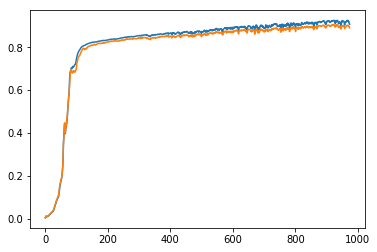

In [29]:
# plot losses
# plt.plot(modelTabnet.history['loss'])

# Plot development of cpc

plt.plot(modelTabnet.history['train_cpc'])
plt.plot(modelTabnet.history['valid_cpc'])

## Training Models - 2. Artificial Neural Network (ANN)  

In [30]:
# define ANN model
# @l : loss function to build model
# @size_hidden_layer : the size of all the hidden layers of the ANN 
# @dropout : the dropout of the model
# @n_layer : the number of hidden layers of the model
# @returns : the defined model
def defineANN(n_features = 20,l=cpc_loss_keras,size_hidden_layer=20,dropout=0.15,n_layer=2):  #l=cpc_loss_keras
    model = Sequential()
    if dropout > 0.0:
        model.add(Dropout(dropout,input_shape=(n_features,)))
    for i in range(n_layer):
        model.add(Dense(size_hidden_layer, activation='relu', input_shape=(n_features,)))
    model.add(Dense(1))
    opt = keras.optimizers.Adam(learning_rate=0.002, clipnorm = 2)
    model.compile(optimizer=opt, loss=l, metrics = custom_metrics_keras)
#  model.compile(optimizer='adam'(lr=0.001), loss=l, metrics = custom_metrics_keras)

    return model

In [31]:
modelAnn = defineANN()
#es = EarlyStopping(monitor='val_cpc_keras', mode='max', verbose=1, patience=200)
historyAnn = modelAnn.fit(X_train, y_train, epochs=1000, batch_size=256, verbose=1, validation_data=(X_valid, y_valid))
#historyAnn = modelAnn.fit(X_train, y_train, epochs=2000, batch_size=256, verbose=1, validation_data=(X_valid, y_valid), callbacks=[es])


Epoch 1/1000
78/78 [==============================] - 3s 21ms/step - loss: 1.0434 - mae: 686.2431 - mse: 31374636.0728 - root_mean_squared_error: 5400.8781 - r_squared_keras: -4540884.8647 - cpc_keras: -0.0431 - val_loss: 0.9172 - val_mae: 73.1495 - val_mse: 41374.0820 - val_root_mean_squared_error: 203.4062 - val_r_squared_keras: -5896.6689 - val_cpc_keras: 0.0898
Epoch 2/1000
78/78 [==============================] - 0s 3ms/step - loss: -0.5542 - mae: 62.5486 - mse: 194845.4765 - root_mean_squared_error: 420.7692 - r_squared_keras: -28068.3702 - cpc_keras: 1.5538 - val_loss: 0.9087 - val_mae: 72.0985 - val_mse: 329777.1562 - val_root_mean_squared_error: 574.2623 - val_r_squared_keras: -47119.8359 - val_cpc_keras: 0.0969
Epoch 3/1000
78/78 [==============================] - 0s 3ms/step - loss: 1.1915 - mae: 45.9762 - mse: 98045.4012 - root_mean_squared_error: 303.9290 - r_squared_keras: -8307787.4751 - cpc_keras: -0.1914 - val_loss: 0.9202 - val_mae: 84.2995 - val_mse: 466790.8438 - va

Epoch 24/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.8996 - mae: 13.7623 - mse: 12489.2361 - root_mean_squared_error: 93.5984 - r_squared_keras: -1713.0713 - cpc_keras: 0.1004 - val_loss: 0.2643 - val_mae: 6.7225 - val_mse: 4327.8096 - val_root_mean_squared_error: 65.7861 - val_r_squared_keras: -618.1796 - val_cpc_keras: 0.7345
Epoch 25/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.7315 - mae: 12.0815 - mse: 16685.3163 - root_mean_squared_error: 123.2777 - r_squared_keras: -2404.7648 - cpc_keras: 0.2686 - val_loss: 18.2248 - val_mae: 9.8885 - val_mse: 21961.0078 - val_root_mean_squared_error: 148.1925 - val_r_squared_keras: -3139.4243 - val_cpc_keras: -15.5756
Epoch 26/1000
78/78 [==============================] - 0s 4ms/step - loss: 0.7296 - mae: 12.0747 - mse: 17687.1857 - root_mean_squared_error: 122.1845 - r_squared_keras: -2426.1114 - cpc_keras: 0.2704 - val_loss: 0.4850 - val_mae: 4.2561 - val_mse: 1174.5121 - val_root_mean_squared_er

78/78 [==============================] - 0s 3ms/step - loss: 0.4475 - mae: 6.1686 - mse: 12157.4095 - root_mean_squared_error: 106.0489 - r_squared_keras: -1780.7032 - cpc_keras: 0.5526 - val_loss: 0.3682 - val_mae: 3.9255 - val_mse: 2303.0198 - val_root_mean_squared_error: 47.9898 - val_r_squared_keras: -328.3427 - val_cpc_keras: 0.6496
Epoch 48/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.5719 - mae: 4.9826 - mse: 4257.1999 - root_mean_squared_error: 62.5643 - r_squared_keras: -600.7507 - cpc_keras: 0.4282 - val_loss: 0.4520 - val_mae: 6.0190 - val_mse: 7929.6162 - val_root_mean_squared_error: 89.0484 - val_r_squared_keras: -1132.6755 - val_cpc_keras: 0.5710
Epoch 49/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.4904 - mae: 4.1416 - mse: 1067.5369 - root_mean_squared_error: 30.5097 - r_squared_keras: -152.0095 - cpc_keras: 0.5096 - val_loss: 0.4244 - val_mae: 5.1793 - val_mse: 5185.3130 - val_root_mean_squared_error: 72.0091 - val_r_square

78/78 [==============================] - 0s 3ms/step - loss: 0.2963 - mae: 2.8017 - mse: 1639.4190 - root_mean_squared_error: 38.2978 - r_squared_keras: -236.5763 - cpc_keras: 0.7037 - val_loss: 0.4188 - val_mae: 5.0030 - val_mse: 4064.6738 - val_root_mean_squared_error: 63.7548 - val_r_squared_keras: -579.9633 - val_cpc_keras: 0.6008
Epoch 71/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.3560 - mae: 3.5217 - mse: 3144.8763 - root_mean_squared_error: 43.3878 - r_squared_keras: -441.3558 - cpc_keras: 0.6440 - val_loss: 0.2960 - val_mae: 2.6671 - val_mse: 704.2900 - val_root_mean_squared_error: 26.5385 - val_r_squared_keras: -99.8662 - val_cpc_keras: 0.7102
Epoch 72/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.2266 - mae: 2.7656 - mse: 1240.3543 - root_mean_squared_error: 33.8602 - r_squared_keras: -193.1518 - cpc_keras: 0.7734 - val_loss: 0.4844 - val_mae: 7.7842 - val_mse: 19581.9043 - val_root_mean_squared_error: 139.9354 - val_r_squared_ke

78/78 [==============================] - 0s 3ms/step - loss: 0.3118 - mae: 2.6473 - mse: 436.1545 - root_mean_squared_error: 19.8036 - r_squared_keras: -65.3479 - cpc_keras: 0.6882 - val_loss: 0.3438 - val_mae: 3.8588 - val_mse: 3787.4797 - val_root_mean_squared_error: 61.5425 - val_r_squared_keras: -540.5782 - val_cpc_keras: 0.6765
Epoch 94/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.2240 - mae: 2.5202 - mse: 1020.4725 - root_mean_squared_error: 30.6051 - r_squared_keras: -137.3900 - cpc_keras: 0.7757 - val_loss: 0.3845 - val_mae: 4.7186 - val_mse: 5283.6558 - val_root_mean_squared_error: 72.6888 - val_r_squared_keras: -754.3915 - val_cpc_keras: 0.6393
Epoch 95/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.3712 - mae: 2.8977 - mse: 845.1847 - root_mean_squared_error: 28.2800 - r_squared_keras: -122.2099 - cpc_keras: 0.6291 - val_loss: 0.2735 - val_mae: 2.4625 - val_mse: 914.9519 - val_root_mean_squared_error: 30.2482 - val_r_squared_keras:

78/78 [==============================] - 0s 3ms/step - loss: 0.3385 - mae: 2.3630 - mse: 565.4810 - root_mean_squared_error: 22.0321 - r_squared_keras: -76.1886 - cpc_keras: 0.6616 - val_loss: 0.2185 - val_mae: 1.6842 - val_mse: 177.5786 - val_root_mean_squared_error: 13.3259 - val_r_squared_keras: -24.4201 - val_cpc_keras: 0.7910
Epoch 117/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1963 - mae: 2.7864 - mse: 1923.8188 - root_mean_squared_error: 41.7348 - r_squared_keras: -272.4102 - cpc_keras: 0.8038 - val_loss: 46.8401 - val_mae: 2.6924 - val_mse: 1004.2504 - val_root_mean_squared_error: 31.6899 - val_r_squared_keras: -142.6038 - val_cpc_keras: -41.5347
Epoch 118/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.2142 - mae: 2.9140 - mse: 1940.1604 - root_mean_squared_error: 40.9172 - r_squared_keras: -248.6622 - cpc_keras: 0.7859 - val_loss: 2.8309 - val_mae: 2.3602 - val_mse: 824.7650 - val_root_mean_squared_error: 28.7187 - val_r_squared_ke

Epoch 140/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1758 - mae: 1.1244 - mse: 2.3904 - root_mean_squared_error: 1.5460 - r_squared_keras: 0.6386 - cpc_keras: 0.8243 - val_loss: 0.1689 - val_mae: 1.1762 - val_mse: 2.3367 - val_root_mean_squared_error: 1.5286 - val_r_squared_keras: 0.6296 - val_cpc_keras: 0.8349
Epoch 141/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1733 - mae: 1.1048 - mse: 2.3232 - root_mean_squared_error: 1.5240 - r_squared_keras: 0.6475 - cpc_keras: 0.8268 - val_loss: 0.1800 - val_mae: 1.2678 - val_mse: 2.5697 - val_root_mean_squared_error: 1.6030 - val_r_squared_keras: 0.5961 - val_cpc_keras: 0.8247
Epoch 142/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1815 - mae: 1.1480 - mse: 2.4371 - root_mean_squared_error: 1.5611 - r_squared_keras: 0.6309 - cpc_keras: 0.8185 - val_loss: 0.1648 - val_mae: 1.1373 - val_mse: 2.2402 - val_root_mean_squared_error: 1.4967 - val_r_squared_keras: 0.6485 - val_cpc_

78/78 [==============================] - 0s 4ms/step - loss: 0.1735 - mae: 1.1041 - mse: 2.3669 - root_mean_squared_error: 1.5383 - r_squared_keras: -6503.7759 - cpc_keras: 0.8263 - val_loss: 0.1746 - val_mae: 1.2304 - val_mse: 2.4846 - val_root_mean_squared_error: 1.5763 - val_r_squared_keras: 0.5951 - val_cpc_keras: 0.8287
Epoch 165/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1796 - mae: 1.1422 - mse: 2.4691 - root_mean_squared_error: 1.5709 - r_squared_keras: 0.6305 - cpc_keras: 0.8204 - val_loss: 0.1664 - val_mae: 1.1600 - val_mse: 2.3029 - val_root_mean_squared_error: 1.5175 - val_r_squared_keras: 0.6317 - val_cpc_keras: 0.8376
Epoch 166/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1740 - mae: 1.1103 - mse: 2.3551 - root_mean_squared_error: 1.5344 - r_squared_keras: 0.6423 - cpc_keras: 0.8260 - val_loss: 0.1619 - val_mae: 1.1060 - val_mse: 2.1838 - val_root_mean_squared_error: 1.4778 - val_r_squared_keras: 0.6553 - val_cpc_keras: 0.84

78/78 [==============================] - 0s 3ms/step - loss: 0.1725 - mae: 1.0819 - mse: 2.2699 - root_mean_squared_error: 1.5065 - r_squared_keras: 0.6576 - cpc_keras: 0.8276 - val_loss: 0.1643 - val_mae: 1.1374 - val_mse: 2.2207 - val_root_mean_squared_error: 1.4902 - val_r_squared_keras: 0.6554 - val_cpc_keras: 0.8403
Epoch 189/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1722 - mae: 1.1022 - mse: 2.4113 - root_mean_squared_error: 1.5525 - r_squared_keras: 0.6464 - cpc_keras: 0.8278 - val_loss: 0.1588 - val_mae: 1.0809 - val_mse: 2.1156 - val_root_mean_squared_error: 1.4545 - val_r_squared_keras: 0.6709 - val_cpc_keras: 0.8455
Epoch 190/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1703 - mae: 1.0835 - mse: 2.2835 - root_mean_squared_error: 1.5111 - r_squared_keras: 0.6576 - cpc_keras: 0.8296 - val_loss: 0.1721 - val_mae: 1.2136 - val_mse: 2.4168 - val_root_mean_squared_error: 1.5546 - val_r_squared_keras: 0.6136 - val_cpc_keras: 0.8318
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1680 - mae: 1.0636 - mse: 2.2068 - root_mean_squared_error: 1.4854 - r_squared_keras: 0.6705 - cpc_keras: 0.8320 - val_loss: 0.1734 - val_mae: 1.2193 - val_mse: 2.4322 - val_root_mean_squared_error: 1.5595 - val_r_squared_keras: 0.6095 - val_cpc_keras: 0.8304
Epoch 213/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1707 - mae: 1.0839 - mse: 2.3025 - root_mean_squared_error: 1.5171 - r_squared_keras: 0.6522 - cpc_keras: 0.8293 - val_loss: 0.1600 - val_mae: 1.0972 - val_mse: 2.1307 - val_root_mean_squared_error: 1.4597 - val_r_squared_keras: 0.6695 - val_cpc_keras: 0.8446
Epoch 214/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1699 - mae: 1.0693 - mse: 2.2123 - root_mean_squared_error: 1.4873 - r_squared_keras: 0.6608 - cpc_keras: 0.8301 - val_loss: 0.1660 - val_mae: 1.1569 - val_mse: 2.2512 - val_root_mean_squared_error: 1.5004 - val_r_squared_keras: 0.6528 - val_cpc_keras: 0.8389
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1701 - mae: 1.0729 - mse: 2.2262 - root_mean_squared_error: 1.4920 - r_squared_keras: 0.6657 - cpc_keras: 0.8299 - val_loss: 0.1651 - val_mae: 1.1381 - val_mse: 2.2376 - val_root_mean_squared_error: 1.4959 - val_r_squared_keras: 0.6484 - val_cpc_keras: 0.8389
Epoch 237/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1694 - mae: 1.0787 - mse: 2.2575 - root_mean_squared_error: 1.5024 - r_squared_keras: -259.5042 - cpc_keras: 0.8310 - val_loss: 0.1638 - val_mae: 1.1288 - val_mse: 2.1911 - val_root_mean_squared_error: 1.4803 - val_r_squared_keras: 0.6612 - val_cpc_keras: 0.8407
Epoch 238/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1684 - mae: 1.0728 - mse: 2.2495 - root_mean_squared_error: 1.4998 - r_squared_keras: 0.6649 - cpc_keras: 0.8315 - val_loss: 0.1799 - val_mae: 1.2802 - val_mse: 5.8258 - val_root_mean_squared_error: 2.4137 - val_r_squared_keras: 0.1280 - val_cpc_keras: 0.824

78/78 [==============================] - 0s 3ms/step - loss: 0.1767 - mae: 1.1160 - mse: 3.6826 - root_mean_squared_error: 1.8956 - r_squared_keras: 0.4360 - cpc_keras: 0.8232 - val_loss: 0.1607 - val_mae: 1.1098 - val_mse: 2.1730 - val_root_mean_squared_error: 1.4741 - val_r_squared_keras: 0.6617 - val_cpc_keras: 0.8435
Epoch 261/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1713 - mae: 1.0835 - mse: 2.2753 - root_mean_squared_error: 1.5078 - r_squared_keras: 0.6567 - cpc_keras: 0.8286 - val_loss: 0.1741 - val_mae: 1.2261 - val_mse: 2.4405 - val_root_mean_squared_error: 1.5622 - val_r_squared_keras: 0.6124 - val_cpc_keras: 0.8295
Epoch 262/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1747 - mae: 1.1174 - mse: 2.3396 - root_mean_squared_error: 1.5294 - r_squared_keras: 0.6495 - cpc_keras: 0.8253 - val_loss: 0.1719 - val_mae: 1.1967 - val_mse: 2.3751 - val_root_mean_squared_error: 1.5412 - val_r_squared_keras: 0.6324 - val_cpc_keras: 0.8329
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1674 - mae: 1.0680 - mse: 2.3307 - root_mean_squared_error: 1.5263 - r_squared_keras: 0.6506 - cpc_keras: 0.8325 - val_loss: 0.1651 - val_mae: 1.1606 - val_mse: 2.3088 - val_root_mean_squared_error: 1.5195 - val_r_squared_keras: 0.6299 - val_cpc_keras: 0.8378
Epoch 285/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1690 - mae: 1.0757 - mse: 2.2669 - root_mean_squared_error: 1.5054 - r_squared_keras: 0.6582 - cpc_keras: 0.8311 - val_loss: 0.1576 - val_mae: 1.0829 - val_mse: 2.0991 - val_root_mean_squared_error: 1.4488 - val_r_squared_keras: 0.6790 - val_cpc_keras: 0.8472
Epoch 286/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1688 - mae: 1.0745 - mse: 2.2657 - root_mean_squared_error: 1.5052 - r_squared_keras: 0.6178 - cpc_keras: 0.8311 - val_loss: 0.1572 - val_mae: 1.0806 - val_mse: 2.0863 - val_root_mean_squared_error: 1.4444 - val_r_squared_keras: 0.6783 - val_cpc_keras: 0.8470
E

78/78 [==============================] - 0s 2ms/step - loss: 0.1651 - mae: 1.0442 - mse: 2.2040 - root_mean_squared_error: 1.4845 - r_squared_keras: 0.6652 - cpc_keras: 0.8348 - val_loss: 0.1427 - val_mae: 0.9497 - val_mse: 1.8402 - val_root_mean_squared_error: 1.3565 - val_r_squared_keras: 0.7220 - val_cpc_keras: 0.8621
Epoch 309/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1684 - mae: 1.0580 - mse: 2.2180 - root_mean_squared_error: 1.4891 - r_squared_keras: 0.6631 - cpc_keras: 0.8316 - val_loss: 0.1583 - val_mae: 1.1044 - val_mse: 2.1621 - val_root_mean_squared_error: 1.4704 - val_r_squared_keras: 0.6657 - val_cpc_keras: 0.8466
Epoch 310/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1638 - mae: 1.0488 - mse: 2.1559 - root_mean_squared_error: 1.4683 - r_squared_keras: 0.6737 - cpc_keras: 0.8362 - val_loss: 0.1607 - val_mae: 1.1221 - val_mse: 2.1976 - val_root_mean_squared_error: 1.4824 - val_r_squared_keras: 0.6683 - val_cpc_keras: 0.8451
E

78/78 [==============================] - 0s 2ms/step - loss: 0.1618 - mae: 1.0302 - mse: 2.1200 - root_mean_squared_error: 1.4551 - r_squared_keras: 0.6755 - cpc_keras: 0.8381 - val_loss: 0.1628 - val_mae: 1.1410 - val_mse: 2.1933 - val_root_mean_squared_error: 1.4810 - val_r_squared_keras: 0.6580 - val_cpc_keras: 0.8416
Epoch 333/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1603 - mae: 1.0226 - mse: 2.0976 - root_mean_squared_error: 1.4482 - r_squared_keras: 0.6810 - cpc_keras: 0.8397 - val_loss: 0.1496 - val_mae: 1.0190 - val_mse: 1.9241 - val_root_mean_squared_error: 1.3871 - val_r_squared_keras: 0.7108 - val_cpc_keras: 0.8556
Epoch 334/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1643 - mae: 1.0416 - mse: 2.1242 - root_mean_squared_error: 1.4571 - r_squared_keras: 0.6776 - cpc_keras: 0.8357 - val_loss: 0.1521 - val_mae: 1.0295 - val_mse: 1.9799 - val_root_mean_squared_error: 1.4071 - val_r_squared_keras: 0.7042 - val_cpc_keras: 0.8530
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1618 - mae: 1.0373 - mse: 2.1370 - root_mean_squared_error: 1.4618 - r_squared_keras: 0.6780 - cpc_keras: 0.8382 - val_loss: 0.1475 - val_mae: 0.9830 - val_mse: 1.8549 - val_root_mean_squared_error: 1.3620 - val_r_squared_keras: 0.7233 - val_cpc_keras: 0.8580
Epoch 357/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1643 - mae: 1.0351 - mse: 2.1316 - root_mean_squared_error: 1.4598 - r_squared_keras: 0.6761 - cpc_keras: 0.8356 - val_loss: 0.1671 - val_mae: 1.1832 - val_mse: 2.3347 - val_root_mean_squared_error: 1.5280 - val_r_squared_keras: 0.6378 - val_cpc_keras: 0.8377
Epoch 358/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1647 - mae: 1.0497 - mse: 2.1333 - root_mean_squared_error: 1.4605 - r_squared_keras: 0.6816 - cpc_keras: 0.8352 - val_loss: 0.1543 - val_mae: 1.0529 - val_mse: 1.9854 - val_root_mean_squared_error: 1.4090 - val_r_squared_keras: 0.7061 - val_cpc_keras: 0.8516
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1614 - mae: 1.0344 - mse: 2.1044 - root_mean_squared_error: 1.4506 - r_squared_keras: 0.6845 - cpc_keras: 0.8386 - val_loss: 0.1589 - val_mae: 1.1082 - val_mse: 2.1211 - val_root_mean_squared_error: 1.4564 - val_r_squared_keras: 0.6744 - val_cpc_keras: 0.8461
Epoch 381/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1647 - mae: 1.0567 - mse: 2.2001 - root_mean_squared_error: 1.4831 - r_squared_keras: -3221.7807 - cpc_keras: 0.8350 - val_loss: 0.1558 - val_mae: 1.0678 - val_mse: 2.0223 - val_root_mean_squared_error: 1.4221 - val_r_squared_keras: 0.6917 - val_cpc_keras: 0.8489
Epoch 382/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1643 - mae: 1.0374 - mse: 2.1581 - root_mean_squared_error: 1.4690 - r_squared_keras: 0.6643 - cpc_keras: 0.8357 - val_loss: 0.1581 - val_mae: 1.0981 - val_mse: 2.1077 - val_root_mean_squared_error: 1.4518 - val_r_squared_keras: 0.6866 - val_cpc_keras: 0.84

78/78 [==============================] - 0s 3ms/step - loss: 0.1670 - mae: 1.0699 - mse: 2.2270 - root_mean_squared_error: 1.4916 - r_squared_keras: 0.6650 - cpc_keras: 0.8329 - val_loss: 0.1615 - val_mae: 1.1227 - val_mse: 2.1356 - val_root_mean_squared_error: 1.4614 - val_r_squared_keras: 0.6736 - val_cpc_keras: 0.8432
Epoch 405/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1649 - mae: 1.0476 - mse: 2.1773 - root_mean_squared_error: 1.4755 - r_squared_keras: 0.6715 - cpc_keras: 0.8351 - val_loss: 0.1649 - val_mae: 1.1623 - val_mse: 2.2744 - val_root_mean_squared_error: 1.5081 - val_r_squared_keras: 0.6496 - val_cpc_keras: 0.8402
Epoch 406/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1604 - mae: 1.0248 - mse: 2.0784 - root_mean_squared_error: 1.4415 - r_squared_keras: 0.6849 - cpc_keras: 0.8396 - val_loss: 0.1533 - val_mae: 1.0539 - val_mse: 1.9924 - val_root_mean_squared_error: 1.4115 - val_r_squared_keras: 0.7012 - val_cpc_keras: 0.8519
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1631 - mae: 1.0384 - mse: 2.1795 - root_mean_squared_error: 1.4759 - r_squared_keras: 0.6736 - cpc_keras: 0.8369 - val_loss: 0.1541 - val_mae: 1.0652 - val_mse: 2.0288 - val_root_mean_squared_error: 1.4244 - val_r_squared_keras: 0.6902 - val_cpc_keras: 0.8507
Epoch 429/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1654 - mae: 1.0393 - mse: 2.1669 - root_mean_squared_error: 1.4720 - r_squared_keras: 0.6738 - cpc_keras: 0.8347 - val_loss: 0.1467 - val_mae: 0.9807 - val_mse: 1.8530 - val_root_mean_squared_error: 1.3613 - val_r_squared_keras: 0.7258 - val_cpc_keras: 0.8591
Epoch 430/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1649 - mae: 1.0415 - mse: 2.1607 - root_mean_squared_error: 1.4698 - r_squared_keras: 0.6568 - cpc_keras: 0.8352 - val_loss: 0.1628 - val_mae: 1.1326 - val_mse: 2.1530 - val_root_mean_squared_error: 1.4673 - val_r_squared_keras: 0.6638 - val_cpc_keras: 0.8412
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1607 - mae: 1.0204 - mse: 2.0833 - root_mean_squared_error: 1.4432 - r_squared_keras: 0.6858 - cpc_keras: 0.8393 - val_loss: 0.1517 - val_mae: 1.0320 - val_mse: 1.9497 - val_root_mean_squared_error: 1.3963 - val_r_squared_keras: 0.7053 - val_cpc_keras: 0.8532
Epoch 453/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1616 - mae: 1.0264 - mse: 2.1269 - root_mean_squared_error: 1.4583 - r_squared_keras: 0.6810 - cpc_keras: 0.8383 - val_loss: 0.1539 - val_mae: 1.0678 - val_mse: 2.0411 - val_root_mean_squared_error: 1.4287 - val_r_squared_keras: 0.6925 - val_cpc_keras: 0.8515
Epoch 454/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1630 - mae: 1.0388 - mse: 2.1528 - root_mean_squared_error: 1.4669 - r_squared_keras: 0.6783 - cpc_keras: 0.8370 - val_loss: 0.1501 - val_mae: 1.0220 - val_mse: 1.9415 - val_root_mean_squared_error: 1.3934 - val_r_squared_keras: 0.7076 - val_cpc_keras: 0.8552
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1658 - mae: 1.0492 - mse: 2.1749 - root_mean_squared_error: 1.4745 - r_squared_keras: 0.6704 - cpc_keras: 0.8341 - val_loss: 0.1543 - val_mae: 1.0685 - val_mse: 2.0619 - val_root_mean_squared_error: 1.4359 - val_r_squared_keras: 0.6889 - val_cpc_keras: 0.8511
Epoch 477/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1612 - mae: 1.0191 - mse: 2.0935 - root_mean_squared_error: 1.4467 - r_squared_keras: 0.6840 - cpc_keras: 0.8388 - val_loss: 0.1590 - val_mae: 1.1017 - val_mse: 2.1017 - val_root_mean_squared_error: 1.4497 - val_r_squared_keras: 0.6750 - val_cpc_keras: 0.8452
Epoch 478/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1602 - mae: 1.0242 - mse: 2.0984 - root_mean_squared_error: 1.4485 - r_squared_keras: 0.6829 - cpc_keras: 0.8398 - val_loss: 0.1477 - val_mae: 1.0068 - val_mse: 1.9261 - val_root_mean_squared_error: 1.3878 - val_r_squared_keras: 0.7126 - val_cpc_keras: 0.8576
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1661 - mae: 1.0551 - mse: 2.3976 - root_mean_squared_error: 1.5403 - r_squared_keras: 0.6407 - cpc_keras: 0.8339 - val_loss: 0.1552 - val_mae: 1.0819 - val_mse: 2.0662 - val_root_mean_squared_error: 1.4374 - val_r_squared_keras: 0.6866 - val_cpc_keras: 0.8496
Epoch 501/1000
78/78 [==============================] - 0s 4ms/step - loss: 0.1623 - mae: 1.0352 - mse: 2.1528 - root_mean_squared_error: 1.4671 - r_squared_keras: 0.6769 - cpc_keras: 0.8377 - val_loss: 0.1459 - val_mae: 0.9736 - val_mse: 1.8530 - val_root_mean_squared_error: 1.3612 - val_r_squared_keras: 0.7254 - val_cpc_keras: 0.8596
Epoch 502/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1652 - mae: 1.0506 - mse: 2.2015 - root_mean_squared_error: 1.4836 - r_squared_keras: 0.6693 - cpc_keras: 0.8348 - val_loss: 0.1573 - val_mae: 1.0790 - val_mse: 2.0414 - val_root_mean_squared_error: 1.4288 - val_r_squared_keras: 0.6918 - val_cpc_keras: 0.8479
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1664 - mae: 1.0569 - mse: 2.1810 - root_mean_squared_error: 1.4767 - r_squared_keras: 0.6712 - cpc_keras: 0.8336 - val_loss: 0.1452 - val_mae: 0.9700 - val_mse: 1.8392 - val_root_mean_squared_error: 1.3562 - val_r_squared_keras: 0.7254 - val_cpc_keras: 0.8597
Epoch 525/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1650 - mae: 1.0389 - mse: 2.1382 - root_mean_squared_error: 1.4621 - r_squared_keras: 0.6775 - cpc_keras: 0.8351 - val_loss: 0.1618 - val_mae: 1.1360 - val_mse: 2.2430 - val_root_mean_squared_error: 1.4977 - val_r_squared_keras: 0.6538 - val_cpc_keras: 0.8431
Epoch 526/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1624 - mae: 1.0370 - mse: 2.1195 - root_mean_squared_error: 1.4557 - r_squared_keras: 0.6715 - cpc_keras: 0.8375 - val_loss: 0.1531 - val_mae: 1.0452 - val_mse: 1.9752 - val_root_mean_squared_error: 1.4054 - val_r_squared_keras: 0.7001 - val_cpc_keras: 0.8520
E

78/78 [==============================] - 0s 2ms/step - loss: 0.1645 - mae: 1.0490 - mse: 2.2227 - root_mean_squared_error: 1.4906 - r_squared_keras: 0.6674 - cpc_keras: 0.8353 - val_loss: 0.1463 - val_mae: 0.9864 - val_mse: 1.8739 - val_root_mean_squared_error: 1.3689 - val_r_squared_keras: 0.7233 - val_cpc_keras: 0.8594
Epoch 549/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1640 - mae: 1.0504 - mse: 2.1889 - root_mean_squared_error: 1.4794 - r_squared_keras: 0.5966 - cpc_keras: 0.8360 - val_loss: 0.1426 - val_mae: 0.9463 - val_mse: 1.8111 - val_root_mean_squared_error: 1.3458 - val_r_squared_keras: 0.7324 - val_cpc_keras: 0.8627
Epoch 550/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1624 - mae: 1.0356 - mse: 2.1167 - root_mean_squared_error: 1.4547 - r_squared_keras: 0.6813 - cpc_keras: 0.8375 - val_loss: 0.1577 - val_mae: 1.0928 - val_mse: 2.0834 - val_root_mean_squared_error: 1.4434 - val_r_squared_keras: 0.6827 - val_cpc_keras: 0.8474
E

78/78 [==============================] - 0s 2ms/step - loss: 0.1617 - mae: 1.0261 - mse: 2.1044 - root_mean_squared_error: 1.4504 - r_squared_keras: 0.6793 - cpc_keras: 0.8383 - val_loss: 0.1601 - val_mae: 1.1169 - val_mse: 2.1272 - val_root_mean_squared_error: 1.4585 - val_r_squared_keras: 0.6727 - val_cpc_keras: 0.8445
Epoch 573/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1633 - mae: 1.0388 - mse: 2.1295 - root_mean_squared_error: 1.4592 - r_squared_keras: 0.6734 - cpc_keras: 0.8368 - val_loss: 0.1499 - val_mae: 1.0260 - val_mse: 1.9483 - val_root_mean_squared_error: 1.3958 - val_r_squared_keras: 0.7088 - val_cpc_keras: 0.8557
Epoch 574/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1606 - mae: 1.0263 - mse: 2.0756 - root_mean_squared_error: 1.4401 - r_squared_keras: 0.6873 - cpc_keras: 0.8394 - val_loss: 0.1649 - val_mae: 1.1572 - val_mse: 2.2389 - val_root_mean_squared_error: 1.4963 - val_r_squared_keras: 0.6547 - val_cpc_keras: 0.8396
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1650 - mae: 1.0469 - mse: 2.1930 - root_mean_squared_error: 1.4807 - r_squared_keras: 0.6668 - cpc_keras: 0.8349 - val_loss: 0.1642 - val_mae: 1.1491 - val_mse: 2.2162 - val_root_mean_squared_error: 1.4887 - val_r_squared_keras: 0.6631 - val_cpc_keras: 0.8412
Epoch 597/1000
78/78 [==============================] - 0s 4ms/step - loss: 0.1633 - mae: 1.0514 - mse: 2.1655 - root_mean_squared_error: 1.4711 - r_squared_keras: 0.6765 - cpc_keras: 0.8368 - val_loss: 0.1553 - val_mae: 1.0745 - val_mse: 2.0513 - val_root_mean_squared_error: 1.4322 - val_r_squared_keras: 0.6944 - val_cpc_keras: 0.8504
Epoch 598/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1609 - mae: 1.0281 - mse: 2.0986 - root_mean_squared_error: 1.4485 - r_squared_keras: 0.6815 - cpc_keras: 0.8392 - val_loss: 0.1655 - val_mae: 1.1642 - val_mse: 2.2748 - val_root_mean_squared_error: 1.5082 - val_r_squared_keras: 0.6446 - val_cpc_keras: 0.8390
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1629 - mae: 1.0341 - mse: 2.1273 - root_mean_squared_error: 1.4584 - r_squared_keras: 0.6771 - cpc_keras: 0.8371 - val_loss: 0.1570 - val_mae: 1.0815 - val_mse: 2.0429 - val_root_mean_squared_error: 1.4293 - val_r_squared_keras: 0.6886 - val_cpc_keras: 0.8479
Epoch 621/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1632 - mae: 1.0460 - mse: 2.2025 - root_mean_squared_error: 1.4838 - r_squared_keras: 0.6689 - cpc_keras: 0.8368 - val_loss: 0.1471 - val_mae: 0.9855 - val_mse: 1.8635 - val_root_mean_squared_error: 1.3651 - val_r_squared_keras: 0.7206 - val_cpc_keras: 0.8580
Epoch 622/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1623 - mae: 1.0276 - mse: 2.0900 - root_mean_squared_error: 1.4456 - r_squared_keras: 0.6613 - cpc_keras: 0.8378 - val_loss: 0.1585 - val_mae: 1.1037 - val_mse: 2.1234 - val_root_mean_squared_error: 1.4572 - val_r_squared_keras: 0.6745 - val_cpc_keras: 0.8464
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1609 - mae: 1.0264 - mse: 2.0666 - root_mean_squared_error: 1.4373 - r_squared_keras: 0.6917 - cpc_keras: 0.8390 - val_loss: 0.1554 - val_mae: 1.0689 - val_mse: 2.0337 - val_root_mean_squared_error: 1.4261 - val_r_squared_keras: 0.6978 - val_cpc_keras: 0.8506
Epoch 645/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1640 - mae: 1.0456 - mse: 2.1816 - root_mean_squared_error: 1.4766 - r_squared_keras: -1416.3016 - cpc_keras: 0.8361 - val_loss: 0.1625 - val_mae: 1.1414 - val_mse: 2.2211 - val_root_mean_squared_error: 1.4903 - val_r_squared_keras: 0.6589 - val_cpc_keras: 0.8426
Epoch 646/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1642 - mae: 1.0396 - mse: 2.1440 - root_mean_squared_error: 1.4642 - r_squared_keras: 0.6733 - cpc_keras: 0.8358 - val_loss: 0.1527 - val_mae: 1.0438 - val_mse: 1.9929 - val_root_mean_squared_error: 1.4117 - val_r_squared_keras: 0.7009 - val_cpc_keras: 0.85

78/78 [==============================] - 0s 3ms/step - loss: 0.1644 - mae: 1.0404 - mse: 2.1717 - root_mean_squared_error: 1.4735 - r_squared_keras: 0.6692 - cpc_keras: 0.8356 - val_loss: 0.1493 - val_mae: 1.0162 - val_mse: 1.9369 - val_root_mean_squared_error: 1.3917 - val_r_squared_keras: 0.7099 - val_cpc_keras: 0.8561
Epoch 669/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1640 - mae: 1.0413 - mse: 2.1641 - root_mean_squared_error: 1.4708 - r_squared_keras: 0.6745 - cpc_keras: 0.8360 - val_loss: 0.1535 - val_mae: 1.0494 - val_mse: 1.9770 - val_root_mean_squared_error: 1.4061 - val_r_squared_keras: 0.7055 - val_cpc_keras: 0.8521
Epoch 670/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1627 - mae: 1.0344 - mse: 2.3661 - root_mean_squared_error: 1.5366 - r_squared_keras: 0.6371 - cpc_keras: 0.8373 - val_loss: 0.1587 - val_mae: 1.1073 - val_mse: 2.1353 - val_root_mean_squared_error: 1.4613 - val_r_squared_keras: 0.6746 - val_cpc_keras: 0.8466
E

78/78 [==============================] - 0s 4ms/step - loss: 0.1604 - mae: 1.0148 - mse: 2.0598 - root_mean_squared_error: 1.4351 - r_squared_keras: 0.6859 - cpc_keras: 0.8396 - val_loss: 0.1460 - val_mae: 0.9791 - val_mse: 1.8575 - val_root_mean_squared_error: 1.3629 - val_r_squared_keras: 0.7271 - val_cpc_keras: 0.8597
Epoch 693/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1616 - mae: 1.0177 - mse: 2.0417 - root_mean_squared_error: 1.4287 - r_squared_keras: 0.6919 - cpc_keras: 0.8384 - val_loss: 0.1584 - val_mae: 1.0954 - val_mse: 2.0677 - val_root_mean_squared_error: 1.4380 - val_r_squared_keras: 0.6825 - val_cpc_keras: 0.8461
Epoch 694/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1630 - mae: 1.0343 - mse: 2.0853 - root_mean_squared_error: 1.4439 - r_squared_keras: 0.6791 - cpc_keras: 0.8370 - val_loss: 0.1449 - val_mae: 0.9783 - val_mse: 1.8560 - val_root_mean_squared_error: 1.3624 - val_r_squared_keras: 0.7194 - val_cpc_keras: 0.8600
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1608 - mae: 1.0232 - mse: 2.1012 - root_mean_squared_error: 1.4493 - r_squared_keras: 0.6834 - cpc_keras: 0.8391 - val_loss: 0.1491 - val_mae: 1.0103 - val_mse: 1.9007 - val_root_mean_squared_error: 1.3787 - val_r_squared_keras: 0.7148 - val_cpc_keras: 0.8560
Epoch 717/1000
78/78 [==============================] - 0s 4ms/step - loss: 0.1624 - mae: 1.0308 - mse: 2.1053 - root_mean_squared_error: 1.4509 - r_squared_keras: 0.6818 - cpc_keras: 0.8376 - val_loss: 0.1611 - val_mae: 1.1288 - val_mse: 2.1874 - val_root_mean_squared_error: 1.4790 - val_r_squared_keras: 0.6584 - val_cpc_keras: 0.8434
Epoch 718/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1617 - mae: 1.0406 - mse: 2.1421 - root_mean_squared_error: 1.4633 - r_squared_keras: 0.6760 - cpc_keras: 0.8383 - val_loss: 0.1531 - val_mae: 1.0567 - val_mse: 2.0037 - val_root_mean_squared_error: 1.4155 - val_r_squared_keras: 0.6970 - val_cpc_keras: 0.8520
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1613 - mae: 1.0285 - mse: 2.0985 - root_mean_squared_error: 1.4485 - r_squared_keras: 0.6830 - cpc_keras: 0.8388 - val_loss: 0.1551 - val_mae: 1.0713 - val_mse: 2.0311 - val_root_mean_squared_error: 1.4252 - val_r_squared_keras: 0.6904 - val_cpc_keras: 0.8496
Epoch 741/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1617 - mae: 1.0260 - mse: 2.0871 - root_mean_squared_error: 1.4446 - r_squared_keras: 0.6622 - cpc_keras: 0.8382 - val_loss: 0.1589 - val_mae: 1.1096 - val_mse: 2.1187 - val_root_mean_squared_error: 1.4556 - val_r_squared_keras: 0.6763 - val_cpc_keras: 0.8458
Epoch 742/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1627 - mae: 1.0271 - mse: 2.0953 - root_mean_squared_error: 1.4474 - r_squared_keras: 0.6759 - cpc_keras: 0.8373 - val_loss: 0.1538 - val_mae: 1.0521 - val_mse: 1.9741 - val_root_mean_squared_error: 1.4050 - val_r_squared_keras: 0.7013 - val_cpc_keras: 0.8514
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1640 - mae: 1.0324 - mse: 2.1385 - root_mean_squared_error: 1.4623 - r_squared_keras: 0.6667 - cpc_keras: 0.8361 - val_loss: 0.1522 - val_mae: 1.0515 - val_mse: 2.0187 - val_root_mean_squared_error: 1.4208 - val_r_squared_keras: 0.6918 - val_cpc_keras: 0.8528
Epoch 765/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1611 - mae: 1.0274 - mse: 2.1132 - root_mean_squared_error: 1.4536 - r_squared_keras: 0.6820 - cpc_keras: 0.8389 - val_loss: 0.1582 - val_mae: 1.0971 - val_mse: 2.0872 - val_root_mean_squared_error: 1.4447 - val_r_squared_keras: 0.6775 - val_cpc_keras: 0.8464
Epoch 766/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1588 - mae: 1.0175 - mse: 2.0587 - root_mean_squared_error: 1.4348 - r_squared_keras: 0.6913 - cpc_keras: 0.8411 - val_loss: 0.1655 - val_mae: 1.1742 - val_mse: 2.3061 - val_root_mean_squared_error: 1.5186 - val_r_squared_keras: 0.6359 - val_cpc_keras: 0.8387
E

78/78 [==============================] - 0s 2ms/step - loss: 0.1648 - mae: 1.0430 - mse: 2.1782 - root_mean_squared_error: 1.4758 - r_squared_keras: 0.6684 - cpc_keras: 0.8350 - val_loss: 0.1606 - val_mae: 1.1181 - val_mse: 2.1303 - val_root_mean_squared_error: 1.4596 - val_r_squared_keras: 0.6640 - val_cpc_keras: 0.8431
Epoch 789/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1605 - mae: 1.0224 - mse: 2.0847 - root_mean_squared_error: 1.4438 - r_squared_keras: 0.6847 - cpc_keras: 0.8396 - val_loss: 0.1549 - val_mae: 1.0603 - val_mse: 1.9923 - val_root_mean_squared_error: 1.4115 - val_r_squared_keras: 0.6937 - val_cpc_keras: 0.8498
Epoch 790/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1639 - mae: 1.0400 - mse: 2.1618 - root_mean_squared_error: 1.4701 - r_squared_keras: 0.6736 - cpc_keras: 0.8360 - val_loss: 0.1523 - val_mae: 1.0433 - val_mse: 1.9635 - val_root_mean_squared_error: 1.4012 - val_r_squared_keras: 0.7030 - val_cpc_keras: 0.8527
E

Epoch 812/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1618 - mae: 1.0386 - mse: 2.1663 - root_mean_squared_error: 1.4718 - r_squared_keras: 0.6765 - cpc_keras: 0.8382 - val_loss: 0.1494 - val_mae: 1.0258 - val_mse: 1.9522 - val_root_mean_squared_error: 1.3972 - val_r_squared_keras: 0.7068 - val_cpc_keras: 0.8560
Epoch 813/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1620 - mae: 1.0246 - mse: 2.0958 - root_mean_squared_error: 1.4477 - r_squared_keras: 0.6765 - cpc_keras: 0.8379 - val_loss: 0.1565 - val_mae: 1.0866 - val_mse: 2.0444 - val_root_mean_squared_error: 1.4298 - val_r_squared_keras: 0.6884 - val_cpc_keras: 0.8484
Epoch 814/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1591 - mae: 1.0130 - mse: 2.0453 - root_mean_squared_error: 1.4300 - r_squared_keras: 0.6901 - cpc_keras: 0.8410 - val_loss: 0.1504 - val_mae: 1.0353 - val_mse: 1.9577 - val_root_mean_squared_error: 1.3992 - val_r_squared_keras: 0.7046 - val_cpc_

78/78 [==============================] - 0s 3ms/step - loss: 0.1614 - mae: 1.0198 - mse: 2.1091 - root_mean_squared_error: 1.4522 - r_squared_keras: 0.6830 - cpc_keras: 0.8386 - val_loss: 0.1540 - val_mae: 1.0565 - val_mse: 1.9833 - val_root_mean_squared_error: 1.4083 - val_r_squared_keras: 0.6949 - val_cpc_keras: 0.8504
Epoch 837/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1618 - mae: 1.0276 - mse: 2.1641 - root_mean_squared_error: 1.4709 - r_squared_keras: 0.6699 - cpc_keras: 0.8381 - val_loss: 0.1577 - val_mae: 1.0975 - val_mse: 2.0882 - val_root_mean_squared_error: 1.4451 - val_r_squared_keras: 0.6777 - val_cpc_keras: 0.8468
Epoch 838/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1616 - mae: 1.0240 - mse: 2.1058 - root_mean_squared_error: 1.4510 - r_squared_keras: 0.6810 - cpc_keras: 0.8383 - val_loss: 0.1486 - val_mae: 1.0079 - val_mse: 1.8862 - val_root_mean_squared_error: 1.3734 - val_r_squared_keras: 0.7164 - val_cpc_keras: 0.8564
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1654 - mae: 1.0492 - mse: 2.1532 - root_mean_squared_error: 1.4673 - r_squared_keras: 0.6746 - cpc_keras: 0.8345 - val_loss: 0.1598 - val_mae: 1.1177 - val_mse: 2.1345 - val_root_mean_squared_error: 1.4610 - val_r_squared_keras: 0.6684 - val_cpc_keras: 0.8446
Epoch 861/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1616 - mae: 1.0303 - mse: 2.1456 - root_mean_squared_error: 1.4646 - r_squared_keras: 0.6793 - cpc_keras: 0.8384 - val_loss: 0.1596 - val_mae: 1.1199 - val_mse: 2.1444 - val_root_mean_squared_error: 1.4644 - val_r_squared_keras: 0.6685 - val_cpc_keras: 0.8448
Epoch 862/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1628 - mae: 1.0373 - mse: 2.1310 - root_mean_squared_error: 1.4597 - r_squared_keras: 0.6736 - cpc_keras: 0.8373 - val_loss: 0.1521 - val_mae: 1.0323 - val_mse: 1.9314 - val_root_mean_squared_error: 1.3898 - val_r_squared_keras: 0.7049 - val_cpc_keras: 0.8524
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1614 - mae: 1.0290 - mse: 2.1433 - root_mean_squared_error: 1.4638 - r_squared_keras: 0.6803 - cpc_keras: 0.8386 - val_loss: 0.1645 - val_mae: 1.1605 - val_mse: 2.2496 - val_root_mean_squared_error: 1.4999 - val_r_squared_keras: 0.6504 - val_cpc_keras: 0.8399
Epoch 885/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1608 - mae: 1.0375 - mse: 2.1190 - root_mean_squared_error: 1.4556 - r_squared_keras: -3729.3793 - cpc_keras: 0.8389 - val_loss: 0.1450 - val_mae: 0.9779 - val_mse: 1.8317 - val_root_mean_squared_error: 1.3534 - val_r_squared_keras: 0.7250 - val_cpc_keras: 0.8602
Epoch 886/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1602 - mae: 1.0224 - mse: 2.1058 - root_mean_squared_error: 1.4510 - r_squared_keras: 0.6907 - cpc_keras: 0.8398 - val_loss: 0.1563 - val_mae: 1.0782 - val_mse: 2.0441 - val_root_mean_squared_error: 1.4297 - val_r_squared_keras: 0.6877 - val_cpc_keras: 0.84

78/78 [==============================] - 0s 3ms/step - loss: 0.1597 - mae: 1.0267 - mse: 2.0955 - root_mean_squared_error: 1.4475 - r_squared_keras: 0.6868 - cpc_keras: 0.8403 - val_loss: 0.1629 - val_mae: 1.1360 - val_mse: 2.1833 - val_root_mean_squared_error: 1.4776 - val_r_squared_keras: 0.6614 - val_cpc_keras: 0.8416
Epoch 909/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1624 - mae: 1.0298 - mse: 2.1048 - root_mean_squared_error: 1.4506 - r_squared_keras: 0.6618 - cpc_keras: 0.8377 - val_loss: 0.1491 - val_mae: 1.0160 - val_mse: 1.9379 - val_root_mean_squared_error: 1.3921 - val_r_squared_keras: 0.7079 - val_cpc_keras: 0.8562
Epoch 910/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1619 - mae: 1.0344 - mse: 2.1601 - root_mean_squared_error: 1.4697 - r_squared_keras: 0.6735 - cpc_keras: 0.8381 - val_loss: 0.1662 - val_mae: 1.1678 - val_mse: 2.2453 - val_root_mean_squared_error: 1.4984 - val_r_squared_keras: 0.6518 - val_cpc_keras: 0.8384
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1638 - mae: 1.0543 - mse: 2.1664 - root_mean_squared_error: 1.4716 - r_squared_keras: 0.6551 - cpc_keras: 0.8360 - val_loss: 0.1491 - val_mae: 1.0189 - val_mse: 1.9510 - val_root_mean_squared_error: 1.3968 - val_r_squared_keras: 0.7062 - val_cpc_keras: 0.8558
Epoch 933/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1650 - mae: 1.0460 - mse: 2.2105 - root_mean_squared_error: 1.4860 - r_squared_keras: 0.6694 - cpc_keras: 0.8350 - val_loss: 0.1595 - val_mae: 1.1078 - val_mse: 2.1122 - val_root_mean_squared_error: 1.4533 - val_r_squared_keras: 0.6738 - val_cpc_keras: 0.8452
Epoch 934/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1627 - mae: 1.0292 - mse: 2.1210 - root_mean_squared_error: 1.4563 - r_squared_keras: 0.6780 - cpc_keras: 0.8372 - val_loss: 0.1613 - val_mae: 1.1185 - val_mse: 2.1406 - val_root_mean_squared_error: 1.4631 - val_r_squared_keras: 0.6726 - val_cpc_keras: 0.8438
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1602 - mae: 1.0269 - mse: 2.1034 - root_mean_squared_error: 1.4502 - r_squared_keras: 0.6812 - cpc_keras: 0.8398 - val_loss: 0.1614 - val_mae: 1.1279 - val_mse: 2.1596 - val_root_mean_squared_error: 1.4696 - val_r_squared_keras: 0.6714 - val_cpc_keras: 0.8441
Epoch 957/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1580 - mae: 1.0138 - mse: 2.0231 - root_mean_squared_error: 1.4221 - r_squared_keras: 0.6974 - cpc_keras: 0.8420 - val_loss: 0.1591 - val_mae: 1.0937 - val_mse: 2.0624 - val_root_mean_squared_error: 1.4361 - val_r_squared_keras: 0.6899 - val_cpc_keras: 0.8466
Epoch 958/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1607 - mae: 1.0201 - mse: 2.1178 - root_mean_squared_error: 1.4551 - r_squared_keras: 0.6797 - cpc_keras: 0.8393 - val_loss: 0.1707 - val_mae: 1.2138 - val_mse: 2.4004 - val_root_mean_squared_error: 1.5493 - val_r_squared_keras: 0.6287 - val_cpc_keras: 0.8345
E

78/78 [==============================] - 0s 3ms/step - loss: 0.1635 - mae: 1.0307 - mse: 2.1383 - root_mean_squared_error: 1.4620 - r_squared_keras: 0.5515 - cpc_keras: 0.8365 - val_loss: 0.1459 - val_mae: 0.9772 - val_mse: 1.8274 - val_root_mean_squared_error: 1.3518 - val_r_squared_keras: 0.7260 - val_cpc_keras: 0.8591
Epoch 981/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1619 - mae: 1.0363 - mse: 2.1297 - root_mean_squared_error: 1.4593 - r_squared_keras: 0.6754 - cpc_keras: 0.8381 - val_loss: 0.1610 - val_mae: 1.1258 - val_mse: 2.1781 - val_root_mean_squared_error: 1.4759 - val_r_squared_keras: 0.6690 - val_cpc_keras: 0.8444
Epoch 982/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.1619 - mae: 1.0297 - mse: 2.1364 - root_mean_squared_error: 1.4616 - r_squared_keras: 0.6794 - cpc_keras: 0.8381 - val_loss: 0.1630 - val_mae: 1.1461 - val_mse: 2.2218 - val_root_mean_squared_error: 1.4906 - val_r_squared_keras: 0.6541 - val_cpc_keras: 0.8416
E

In [32]:
historyAnn_loss = historyAnn.history.get('val_cpc_keras')
modelAnn_best_loss = np.max(historyAnn_loss)
modelAnn_best_epoch = historyAnn_loss.index(modelAnn_best_loss)+1

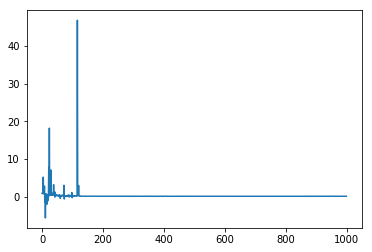

In [33]:
plt.plot(historyAnn.history.get('val_loss'))

In [34]:
print(modelAnn_best_loss, modelAnn_best_epoch)

6.011287212371826 12


## Training Models - 3. Gradient Boosting Trees 

In [35]:
modelXgb = XGBRegressor(max_depth=8,
    learning_rate=0.05,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=random_seed,)

modelXgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=50,
        verbose=10,)

[0]	validation_0-rmse:3.59434
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.34399
[20]	validation_0-rmse:1.63947
[30]	validation_0-rmse:1.27112
[40]	validation_0-rmse:1.07971
[50]	validation_0-rmse:0.986381
[60]	validation_0-rmse:0.931034
[70]	validation_0-rmse:0.905197
[80]	validation_0-rmse:0.883816
[90]	validation_0-rmse:0.864353
[100]	validation_0-rmse:0.853808
[110]	validation_0-rmse:0.846567
[120]	validation_0-rmse:0.84218
[130]	validation_0-rmse:0.836522
[140]	validation_0-rmse:0.831831
[150]	validation_0-rmse:0.825213
[160]	validation_0-rmse:0.820823
[170]	validation_0-rmse:0.817374
[180]	validation_0-rmse:0.814289
[190]	validation_0-rmse:0.812253
[200]	validation_0-rmse:0.808825
[210]	validation_0-rmse:0.806902
[220]	validation_0-rmse:0.804172
[230]	validation_0-rmse:0.802083
[240]	validation_0-rmse:0.800483
[250]	validation_0-rmse:0.799164
[260]	validation_0-rmse:0.797466
[270]	validation_0-rmse:0.795755
[280]	validation_0-rmse:0.79

XGBRegressor(learning_rate=0.05, max_depth=8, n_estimators=1000, n_jobs=-1,
             seed=123, subsample=0.7, verbosity=0)

# Score and evaluate all models

In [36]:
# predictions on test set
y_pred_Ann_test = modelAnn.predict(X_test)
y_pred_Tabnet_test = modelTabnet.predict(X_test)
y_pred_Xgb_test = modelXgb.predict(X_test).reshape(-1,1)

# predictions on train/val set
X_trainval = np.append(X_train, X_valid, axis=0)
y_trainval = np.append(y_train, y_valid, axis=0)

y_pred_Ann_trainval = modelAnn.predict(X_trainval)
y_pred_Tabnet_trainval = modelTabnet.predict(X_trainval)
y_pred_Xgb_trainval = modelXgb.predict(X_trainval).reshape(-1,1)


In [37]:
def eval_performance_allmetrics(y_pred, y_true):
# list of eval metrics ['mae', 'mse', 'rmse', r_squared, CPC]
    mae = mean_absolute_error(y_pred=y_pred, y_true=y_true)
    mse = mean_squared_error(y_pred=y_pred, y_true=y_true, squared=True)
    rmse = mean_squared_error(y_pred=y_pred, y_true=y_true, squared=False)
    r_squared = r2_score(y_pred=y_pred, y_true=y_true)
    cpc = 2 * np.sum(np.minimum((y_true), y_pred)) / (np.sum(y_true) + np.sum(y_pred))
    return [mae, mse, rmse, r_squared, cpc]

In [38]:
performance_metrics_name = ['mae', 'mse', 'rmse', 'r_squared', 'CPC']

performance_Ann_test = eval_performance_allmetrics(y_pred_Ann_test, y_test)
performance_Tabnet_test = eval_performance_allmetrics(y_pred_Tabnet_test, y_test)
performance_Xgb_test = eval_performance_allmetrics(y_pred_Xgb_test, y_test)

performance_Ann_trainval = eval_performance_allmetrics(y_pred_Ann_trainval, y_trainval)
performance_Tabnet_trainval = eval_performance_allmetrics(y_pred_Tabnet_trainval, y_trainval)
performance_Xgb_trainval = eval_performance_allmetrics(y_pred_Xgb_trainval, y_trainval)

In [39]:
print(performance_Ann_test, performance_Tabnet_test, performance_Xgb_test)

[1.0165125, 1.915793, 1.3841218, 0.72534316105785, 0.8558104235497243] [0.7669774, 1.2647842, 1.1246263, 0.8186747543187642, 0.8862010003200004] [0.7066018, 1.0744861, 1.0365742, 0.8459567526885713, 0.8903715197307851]


In [40]:
# performance 
df_metric = pd.DataFrame(np.transpose([performance_metrics_name, performance_Ann_test, performance_Tabnet_test, performance_Xgb_test, performance_Ann_trainval, performance_Tabnet_trainval, performance_Xgb_trainval]), columns=["Metrics", "ANN_on_test", "TabNet_on_test", "XGB_on_test", "ANN_on_trainval", "TabNet_on_trainval", "XGB_on_trainval"])

In [41]:
for col in df_metric:
    if col != "Metrics":
        df_metric[col] = df_metric[col].astype("float").map('{:,.4f}'.format)
    
df_metric

,Metrics,ANN_on_test,TabNet_on_test,XGB_on_test,ANN_on_trainval,TabNet_on_trainval,XGB_on_trainval
0,mae,1.0165,0.7670,0.7066,0.9542,0.4806,0.1535
1,mse,1.9158,1.2648,1.0745,1.7487,0.6342,0.0842
2,rmse,1.3841,1.1246,1.0366,1.3224,0.7963,0.2902
3,r_squared,0.7253,0.8187,0.8460,0.7384,0.9051,0.9874
4,CPC,0.8558,0.8862,0.8904,0.8546,0.9237,0.9756


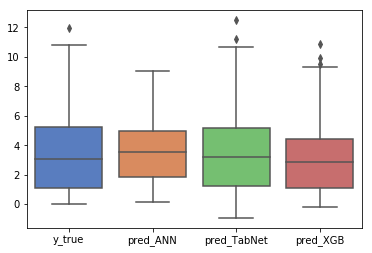

In [42]:
# Range of ground truth versus individual model predicted - BoxPlot
df_pred_test = pd.DataFrame(np.transpose([y_test.flatten(), y_pred_Ann_test.flatten(), y_pred_Tabnet_test.flatten(), y_pred_Xgb_test.flatten()]), columns=["y_true", "pred_ANN", "pred_TabNet", "pred_XGB"])
sns.boxplot(data= df_pred_test, palette="muted")
plt.savefig('./exhibits/prediction_comparison.png')

# Model Intepretations

## Variable Importance (not available for ANN)

In [43]:
#varimp_Ann = np.around(modelAnn.feature_importances_ , decimals=2)
varimp_Tabnet = np.around(modelTabnet.feature_importances_ , decimals=2)
varimp_Xgb = np.around(modelXgb.feature_importances_ , decimals=2)
varimp = pd.DataFrame(np.transpose([np.asarray(features), varimp_Tabnet, varimp_Xgb]), 
                      columns=["features", "varimp_Tabnet", "varimp_Xgb"])

for col in varimp:
    print(col)
    if col != "features":
        varimp[col] = varimp[col].astype("float").map('{:,.2f}'.format)

features
varimp_Tabnet
varimp_Xgb


In [44]:
varimp_melt = pd.melt(varimp, id_vars="features", var_name="model", value_name="variable_importance")
varimp_melt["variable_importance"] = varimp_melt["variable_importance"].astype("float")


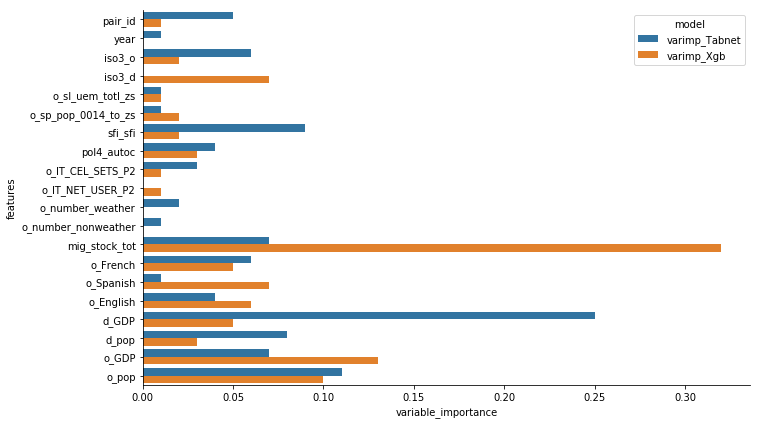

In [45]:
sns.catplot(x='variable_importance', y='features', hue='model', data=varimp_melt, kind='bar', orient="h", 
            height=6, aspect=16/9, legend_out=False)

## Shapley result intepretation 

### Calculations for three fitted models 

In [46]:
shap.initjs()

def modelAnn_predictor(X):
    return modelAnn.predict(X).flatten()

def modelTabnet_predictor(X):
    return modelTabnet.predict(X).flatten()

def modelXgb_predictor(X):
    return modelXgb.predict(X).flatten()

# using a fixed subsample to approximate the whole test set
fixed_subsample=shap.sample(X_test,1000)

explainerANN = shap.KernelExplainer(modelAnn_predictor, shap.sample(X_trainval,50))
shap_valuesANN = explainerANN.shap_values(fixed_subsample, nsamples=500) #use a random 5000 samples to 

explainerTabnet = shap.KernelExplainer(modelTabnet_predictor, shap.sample(X_trainval,50))
shap_valuesTabnet = explainerTabnet.shap_values(fixed_subsample, nsamples=500) #use a random 5000 samples to 

explainerXgb = shap.KernelExplainer(modelXgb_predictor, shap.sample(X_trainval,50))
shap_valuesXgb = explainerXgb.shap_values(fixed_subsample, nsamples=500) #use a random 5000 samples to 

# In theory code below also works, but it runs extremely long
# explainer = shap.KernelExplainer(f, X_trainval)
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
shap_values = shap_valuesTabnet

### Using Shap to create overview summary of relationship between features and target

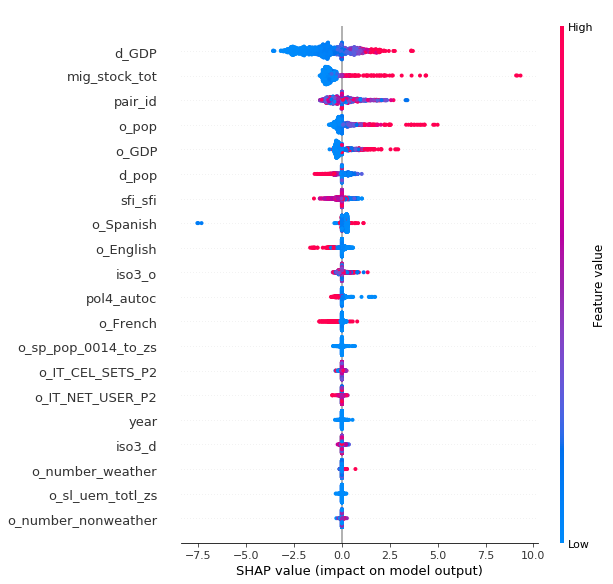

In [48]:
shap.summary_plot(shap_values, fixed_subsample, features, show=False)

### Using Shap to create a variable importance graph

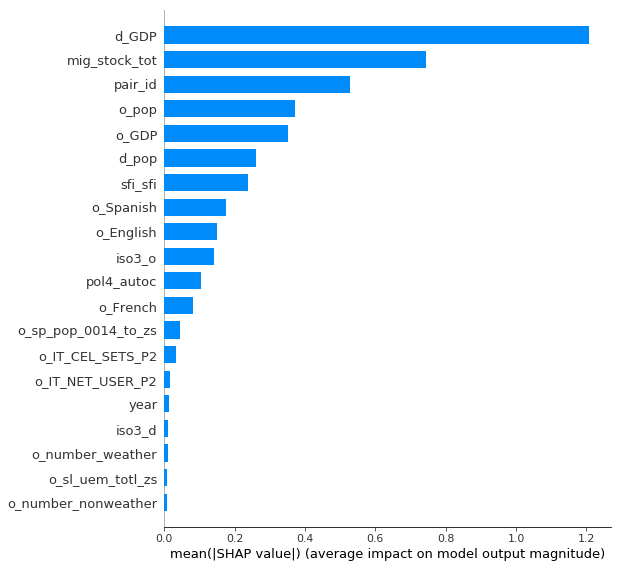

In [49]:
shap.summary_plot(shap_values, fixed_subsample, plot_type="bar", feature_names=features, show=False)

### Using Shap to create a PDP-like insights

SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.

Each dot represents a row of the data. The horizontal location is the actual value from the dataset, and the vertical location shows what having that value did to the prediction. The plots show variation in dot color corresponding to presence of suggested interactions.

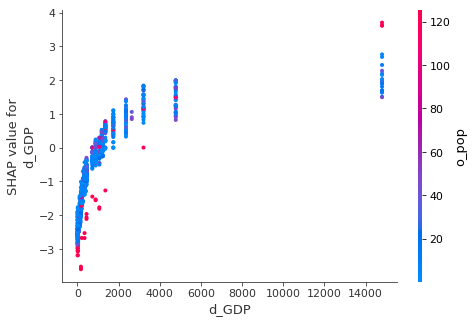

In [50]:
shap.dependence_plot("d_GDP", shap_values, fixed_subsample, features, show=False)

### Using Shap additive force layout

In [51]:
# shap.force_plot(explainer.expected_value, shap_values, features)


### Saving SHAP Exhibits

In [52]:
def generate_shap_Exhibits(shap_values, model, dataset):
    shap.summary_plot(shap_values, fixed_subsample, features, show=False)
    plt.title('{} {} '.format(model, dataset), fontsize=4)
    plt.savefig('./exhibits/{}_shap_overview.png'.format(model), bbox_inches='tight')
    plt.close()

    shap.summary_plot(shap_values, fixed_subsample, plot_type="bar", feature_names=features, show=False)
    plt.title('{} {} '.format(model, dataset), fontsize=4)
    plt.savefig('./exhibits/{}_varimp.png'.format(model), bbox_inches='tight')
    plt.close()

    for f in features:
        shap.dependence_plot(f, shap_values, fixed_subsample, features, show=False)
        plt.title('{} {} '.format(model, dataset), fontsize=4)
        plt.savefig('./exhibits/{}_dp_{}.png'.format(model, f), bbox_inches='tight')
        plt.close()


In [53]:
generate_shap_Exhibits(shap_values=shap_valuesXgb, model="XGB", dataset="on sampled Test set")
generate_shap_Exhibits(shap_values=shap_valuesANN, model="ANN", dataset="on sampled Test set")
generate_shap_Exhibits(shap_values=shap_valuesTabnet, model="TabNet", dataset="on sampled Test set")




# Interpreting TabNet Results

TabNet [3] is an interpretable deep learning architecture from Google AI that ingests tabular data and leverages the layers that comprise its sequential attention mechanism, providing both decision-step and aggregate-feature importance masks.

In [54]:
explain_matrix, masks = modelTabnet.explain(X_test)


Feature importance masks from a TabNet model show the importance of each feature for the top N samples. Feature importance masks (Mask i indicates feature selection at ith step) showing the global instance-wise feature selection. Brighter colors show a higher value. 

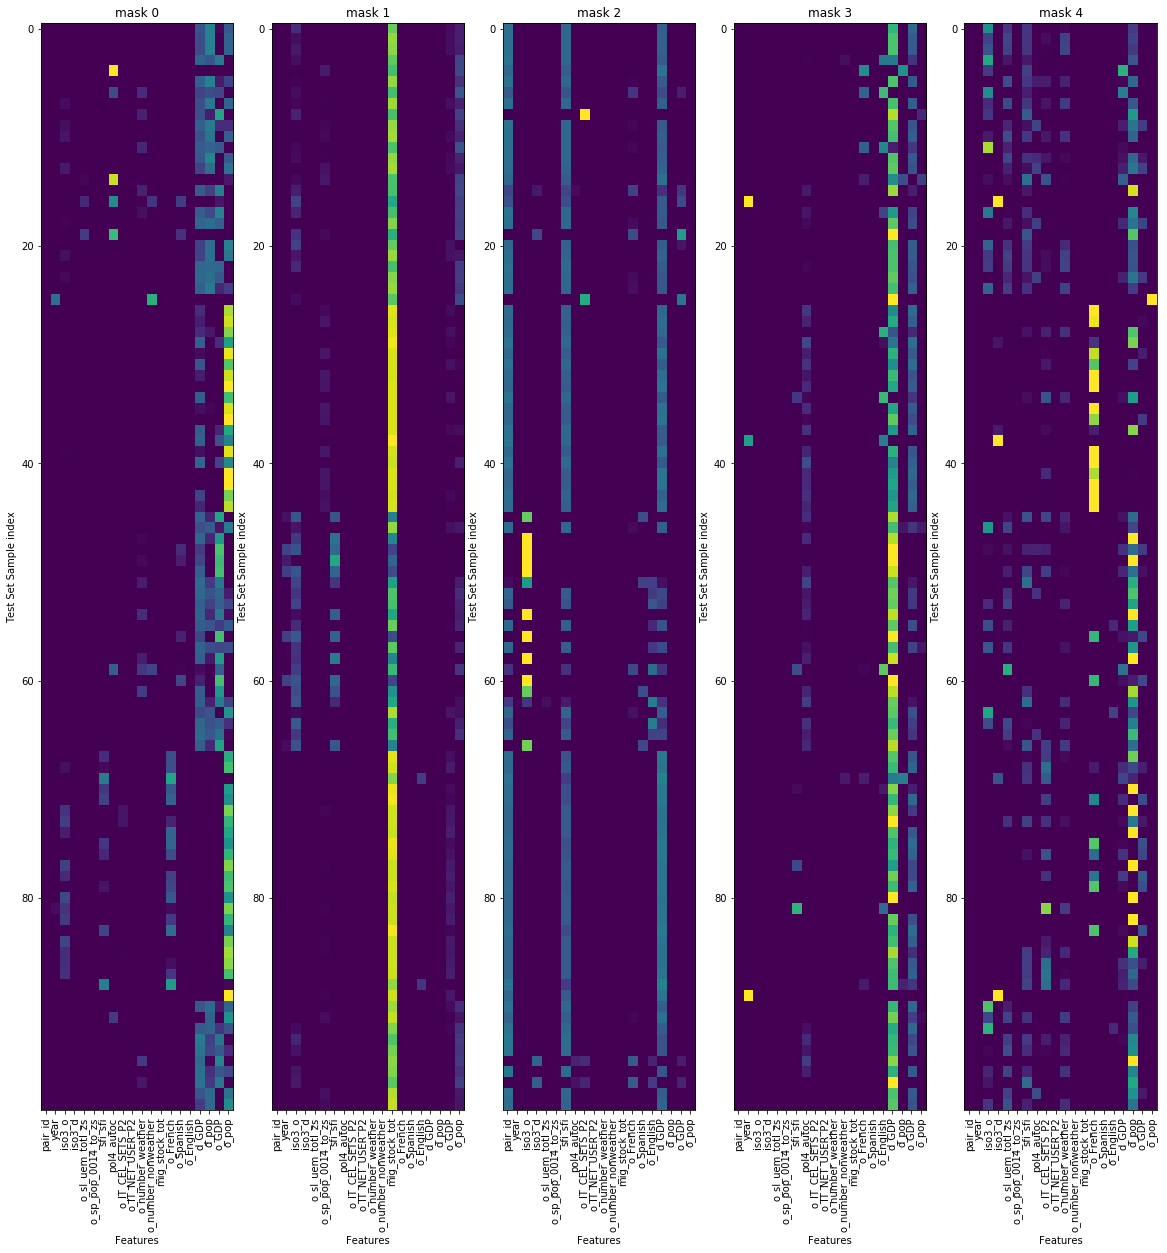

In [55]:
%matplotlib inline
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:100], aspect="auto")
    axs[i].set_title(f"mask {i}")
    axs[i].set_xlabel('Features')
    axs[i].set_ylabel('Test Set Sample index')
    axs[i].xaxis.set_ticks(np.arange(len(features)))
    axs[i].set_xticklabels(features, rotation='vertical')
plt.savefig('./exhibits/TabNet_intepretation.png')

## References ##


[1] N. Golenvaux, P. G. Alvarez, H. S. Kiossou and P. Schaus, "An LSTM approach to Predict Migration based on Google Trends" ArXiv, abs/2005.09902. Published 2020.

[2] M. H. Böhme, A. Gröger, and T. Stöhr, “Searching for a better life: Predicting international migration with online search keywords,” Journal of Development Economics, vol. 142, p. 102347, Jan. 2020, doi: 10.1016/j.jdeveco.2019.04.002.

[3] S. O. Arik, and T. Pfister, "TabNet: Attentive Interpretable Tabular Learning". 2019. arXiv preprint arXiv:1908.07442, 2019. URL: https://arxiv.org/pdf/1908.07442.pdf

[4] A. P. Masucci, J. Serras, A. Johansson, and M. Batty, “Gravity versus radiation models: On the importance of scale and heterogeneity in commuting flows,” Physical Review E, vol. 88, no. 2, p. 022812, 2013.

[5] C. Robinson and B. Dilkina, “A machine learning approach to modeling human migration,” in Proceedings of the 1st ACM SIGCAS Conference on Computing and Sustainable Societies, 2018, pp. 1–8.

[6] F. A. Gers, J. Schmidhuber, and F. Cummins, “Learning to Forget: Continual Prediction with LSTM,” Neural Computation, vol. 12, no. 10, pp. 2451–2471, Oct. 2000, doi: 10.1162/089976600300015015.

[7] S. Hochreiter and J. Schmidhuber, “Long short-term memory,” Neural computation, vol. 9, no. 8, pp. 1735–1780, 1997.

[8] C. Molnar, “Interpretable Machine Learning - A Guide for Making Black Box Models Explainable,” https://christophm.github.io/interpretable-ml-book/index.html

[9] International Migration Institute,”Determinants of International Migration (DEMIG) - POLICY data”. 2021.